# Personal Information
Name: **Nihal Boukhoubza**

StudentID: **14890909**

Email: [**Nihal.boukhoubza@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **23.03.2025**

Github: **https://github.com/NihalBou14/Scriptie**

# Data Context

**Structure of the Primary Database Tables (shopping.db)**

The primary database consists of six tables, each containing a distinct number of records:

- **Customer**: 190 rows  
- **Store**: 64 rows  
- **Product**: 32 rows  
- **ShoppingList**: 492 rows  
- **Purchase**: 509 rows  
- **Inventory**: 829 rows  
These tables include primary keys and foreign key relationships, ensuring referential integrity within the database schema.

**Dataset**

The dataset is derived from IPython log files, capturing SQL query submissions from students. The logs include the following key components:

- **Query**: The raw SQL query text submitted by the student, such as:  
  `query3_2`, `query3_3`, `query3_4`, `query3_5`, `query4_3`, `query4_4`, `query4_5`, `query4_6`, `query4_7`  
- **Timestamp**: The exact time when the query was submitted (e.g., `Tue, 08 Dec 2020 11:14:15`). 

The dataset contains SQL queries from 41 students in week 3 and 33 students in week 4.
The initial count of SQL queries was 4,347, distributed as follows:

- **Week 3**: 1,729 queries  
- **Week 4**: 2,618 queries  
This dataset provides valuable insights into student engagement, query complexity, and potential errors encountered during SQL execution.

# Data Description


**Imports**

In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
import pandas as pd
import re
from IPython.display import display
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import duckdb
from sklearn.ensemble import RandomForestClassifier



**Data loading**

SQlite database

In [2]:
def connect_to_database(db_path):
    return sqlite3.connect(db_path)

def get_table_names(cursor):
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    return [table[0] for table in cursor.fetchall()]

def fetch_table_data(cursor, table_name):
    cursor.execute(f"SELECT * FROM {table_name} LIMIT 20;")  # <-- Top 20
    columns = [desc[0] for desc in cursor.description]  
    rows = cursor.fetchall()  
    return pd.DataFrame(rows, columns=columns) 

def main():
    db_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/shoppingDB_sqlite.sqlite'
    conn = connect_to_database(db_path)
    cursor = conn.cursor()
    
    # Alleen data uit de 'customer' tabel ophalen
    table_name = 'customer'
    print(f"\n Data from Table: {table_name}\n")
    df = fetch_table_data(cursor, table_name)
    
    if df.empty:
        print("⚠️ This table is empty.")
    else:
        print(df.to_string(index=False)) 
    
    conn.close()


if __name__ == "__main__":
    main()



 Data from Table: customer

 cID  cName               street      city
   0   Noah            Koestraat   Utrecht
   1    Sem     Rozemarijnstraat     Breda
   2  Lucas     Oude Leliestraat Amsterdam
   3   Finn        Stationsplein     Breda
   4   Daan         Kalverstraat Amsterdam
   5   Levi       Gasthuisstraat   Utrecht
   6  Milan          Parallelweg   Utrecht
   7   Bram         Schoolstraat Eindhoven
   8   Liam        Rijsbergseweg     Breda
   9 Thomas          Parallelweg Amsterdam
  10    Sam          Langestraat   Tilburg
  11  Thijs            Koestraat   Tilburg
  12   Adam          Nieuwstraat Eindhoven
  13  James      Sint Annastraat     Breda
  14    Max            Eikenlaan   Tilburg
  15   Noud         Koningshoeve   Tilburg
  16 Julian Prins Bernhardstraat Eindhoven
  17    Dex         Kasteeldreef   Tilburg
  18   Hugo         Kasteeldreef   Tilburg
  19   Lars        Rijsbergseweg     Breda


IPython student logs

In [3]:
def open_student_file(submission_week, file_number):
    base_directory_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/VIS_data_Nihal'
    filename = f"{file_number}.py"
    
    file_path = os.path.join(base_directory_path, submission_week, filename)
    
    if not os.path.exists(file_path):
        return f"❌ Bestand niet gevonden: {file_path}"
    
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    # Laatste 20 regels
    last_20 = lines[-20:] if len(lines) >= 20 else lines
    return ''.join(last_20)

submission_week = 'submissions_week3'
file_number = 'pp14'  

file_content = open_student_file(submission_week, file_number)
print(file_content)



#[Out]# 7  189    Koen
# Sat, 28 Nov 2020 23:58:17
query3_4 = '''
    SELECT DISTINCT c.cID, c.cName
    FROM customer c, store s, purchase p
    WHERE c.cID = p.cID
    AND p.sID = s.sID
    AND s.sName = "Kumar"
    AND NOT EXISTS (SELECT *
                    FROM store s1, purchase p1
                    WHERE c.cID = p1.cID
                    AND s1.sID = p1.sID
                    AND s1.sName != "Kumar")
'''

pd.read_sql_query(query3_4, conn)
#[Out]# Empty DataFrame
#[Out]# Columns: [cID, cName]
#[Out]# Index: []




**Data clean up**

I developed a Python script to extract and clean SQL queries from log files, aiming to organize the data for better analysis. Here's a summary of the steps:

**Query Extraction:**
- Implemented the extract_queries function to read log files and extract relevant SQL queries using regex. Removed comments and unnecessary information using re.sub.

**Normalization and Filtering:**
- Normalized queries by removing extra spaces and newlines to prevent hidden duplicates.
- Filtered out empty queries, placeholders (e.g., `"PUT YOUR QUERY HERE"`), and queries containing only spaces.

**Data Collection:**
- Collected queries from .py files in the `submissions_week3` and `submissions_week4` folders.
- Stored each query’s timestamp, name, and content in a list of dictionaries.

**Data Cleaning and Deduplication:**
- Converted the list to a pandas DataFrame and removed duplicate rows.
- Excluded specific queries (`query3_5`, `query4_6`, `query4_7`) identified as experimental or irrelevant.

**Result:**
- Reduced the dataset from 4,347 to 4,236 rows.
- Final dataset includes only unique, relevant queries organized by timestamp, query name, and query content.

In [4]:
def extract_queries(file_path):
    with open(file_path, 'r') as file:
        log_content = file.read()
    log_content = re.sub(r'/\*.*?\*/', '', log_content, flags=re.DOTALL)
    pattern = r'# (\w+, \d+ \w+ \d+ \d+:\d+:\d+).*?\n.*?query(\d+_\d+) = \'\'\'(.*?)\'\'\'' 
    matches = re.findall(pattern, log_content, re.DOTALL)
    data = []
    
    for match in matches:
        timestamp = ' '.join(match[0].split(', ')[1:])
        query_name = match[1]
        query = match[2].strip()
        
        query = ' '.join(query.split())

        if query and query != 'PUT YOUR QUERY HERE' and not query.isspace() and '\\' not in query:
            data.append({'Timestamp': timestamp, 'Query Name': query_name, 'Query': query})
    
    return data

base_directory_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/VIS_data_Nihal'
folders = ['submissions_week3', 'submissions_week4']

all_queries = []
for folder in folders:
    folder_path = os.path.join(base_directory_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.py'):
            file_path = os.path.join(folder_path, file)
            queries = extract_queries(file_path)
            all_queries.extend(queries)

queries_df = pd.DataFrame(all_queries).drop_duplicates()

# Filteren op specifieke querynamen
queries_df = queries_df[~queries_df['Query Name'].isin(['3_5', '4_6', '4_7'])].reset_index(drop=True)

display(queries_df)


,Timestamp,Query Name,Query
0,28 Nov 2020 14:50:54,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin..."
1,28 Nov 2020 14:51:00,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin..."
2,28 Nov 2020 14:51:52,3_2,SELECT * FROM purchase
3,28 Nov 2020 14:52:40,3_2,"SELECT * FROM purchase WHERE data LIKE ""2018"""
4,28 Nov 2020 14:52:45,3_2,SELECT * FROM purchase WHERE data LIKE '2018'
...,...,...,...
4231,09 Dec 2020 12:40:16,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...
4232,09 Dec 2020 12:40:22,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...
4233,09 Dec 2020 12:41:07,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...
4234,09 Dec 2020 12:42:20,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...


In onderstaande code is de output van de code waar de correctheid van de query is gecontroleerd:

2 = correct antwoord

0 = fout antwoord (semantic error)

1 = er was een fout (logic/syntax error)

In [5]:
import pandas as pd

# Pad naar je bestand
bestandspad = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/output_correct.csv'
error = pd.read_csv(bestandspad, sep='─', engine='python', usecols=['Folder', 'File', 'Timestamp', 'Query Name', 'Query','correct' ])


# Eerste paar rijen tonen
display(error)


,Folder,File,Timestamp,Query Name,Query,correct
0,submissions_week3,pp1.py,2020-11-28 14:50:54,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0
1,submissions_week3,pp1.py,2020-11-28 14:51:00,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0
2,submissions_week3,pp1.py,2020-11-28 14:51:52,3_2,SELECT * FROM purchase,0
3,submissions_week3,pp1.py,2020-11-28 14:52:40,3_2,"SELECT * FROM purchase WHERE data LIKE ""2018""",1
4,submissions_week3,pp1.py,2020-11-28 14:52:45,3_2,SELECT * FROM purchase WHERE data LIKE '2018',1
...,...,...,...,...,...,...
4231,submissions_week4,pp9.py,2020-12-09 12:40:16,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0
4232,submissions_week4,pp9.py,2020-12-09 12:40:22,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0
4233,submissions_week4,pp9.py,2020-12-09 12:41:07,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,1
4234,submissions_week4,pp9.py,2020-12-09 12:42:20,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0


**Data Analysis**


After the initial data cleanup, I enriched the dataset by adding additional columns to capture various aspects of the SQL queries, such as error types, query complexity metrics, and keyword usage. To achieve this, I implemented several functions to analyze queries, including counting brackets, tables, words, subqueries, and conditions in the `WHERE` clause. I also developed functions to identify invalid columns and tables, as well as to count comments within the queries.

To categorize errors, I created a function called `categorize_error` that classifies errors into syntax errors, logic errors, conceptual errors, or unknown errors based on the error message. Additionally, I implemented a `count_keywords` function to track the usage of SQL keywords like `SELECT`, `FROM`, `WHERE`, and `JOIN`, among others. Each query was executed against an SQLite database to capture errors, and the error messages were logged and categorized.

The enriched dataset now includes columns for error presence and type, counts of brackets, tables, keywords, and conditions, as well as query length, word count, and subquery count. Invalid columns and tables were also identified and counted. After combining all the data into a pandas DataFrame, I removed duplicates and filtered out irrelevant queries (3_5, 4_6, 4_7). The final dataset was exported to a CSV file for further analysis.

This process provided valuable insights into query structure and error patterns, enabling a more comprehensive analysis of common issues and query complexity.

In [6]:
def count_brackets(query):
    return query.count('(') + query.count(')')

def count_tables(query, table_list):
    return len(set(table for table in table_list if table in query.lower()))

def query_length(query):
    return len(query)

def word_count(query):
    return len(query.split())

def count_subqueries(query):
    return query.lower().count('select') - 1

def count_where_conditions(query):
    where_index = query.lower().find('where')
    if where_index == -1:
        return 0
    where_clause = query[where_index + 5:]
    return where_clause.count('and') + where_clause.count('or') + 1

def count_comments(query):
    return query.lower().count('--') + query.lower().count('/*')

def count_invalid_columns(query, valid_columns):
    query_lower = query.lower()
    columns_in_query = re.findall(r'\b\w+\.\w+\b', query_lower)
    column_names = [column.split('.')[1] for column in columns_in_query]
    valid_columns_lower = [col.lower() for col in valid_columns]
    return sum(1 for column in column_names if column not in valid_columns_lower)

def count_invalid_tables(query, valid_tables):
    query_lower = query.lower()
    tables_in_query = re.findall(r'\bfrom\s+(\w+)', query_lower, re.IGNORECASE)
    valid_tables_lower = [table.lower() for table in valid_tables]
    return sum(1 for table in tables_in_query if table not in valid_tables_lower)

def extract_queries_and_timestamps(file_path):
    with open(file_path, 'r') as file:
        log_content = file.read()
    log_content = re.sub(r'/\*.*?\*/', '', log_content, flags=re.DOTALL)
    pattern = r'# (\w+, \d+ \w+ \d+ \d+:\d+:\d+).*?\n.*?query(\d+_\d+) = \'\'\'(.*?)\'\'\'' 
    matches = re.findall(pattern, log_content, re.DOTALL)
    data = []
    table_names = ['store', 'shoppinglist', 'purchase', 'product', 'inventory', 'customer']
    valid_columns = ['cid', 'cname', 'street', 'city', 'sid', 'sname', 'pid', 'pname', 'suffix', 'quantity', 'date', 'tid', 'price', 'unit_price']
    for match in matches:
        timestamp = ' '.join(match[0].split(', ')[1:])
        query_name = match[1]
        query = match[2].strip()
        query = ' '.join(query.split())
        if query and query != 'PUT YOUR QUERY HERE' and not query.isspace() and '\\' not in query:
            bracket_count = count_brackets(query)
            table_count = count_tables(query, table_names)
            length_count = query_length(query)
            word_count_value = word_count(query)  # Renamed variable
            subquery_count = count_subqueries(query)
            comments_count = count_comments(query)
            invalid_columns_count = count_invalid_columns(query, valid_columns)
            invalid_tables_count = count_invalid_tables(query, table_names)
            where_conditions_count = count_where_conditions(query)
            data.append((timestamp, query, query_name, bracket_count, table_count, length_count, word_count_value, subquery_count, comments_count, invalid_columns_count,  invalid_tables_count, where_conditions_count))
    return data


def count_keywords(query):
    keywords = ['select', 'with', 'from', 'where', 'group by', 'join','having', 'distinct', 'order by', 'count', 'sum',  'max', 'limit', 'union', 'as', '=', '>', '<', 'like', 'in']
    keyword_counts = {keyword: query.lower().count(keyword) for keyword in keywords}
    keyword_counts['group by & having'] = 1 if 'group by' in query.lower() and 'having' in query.lower() else 0
    return keyword_counts

def categorize_error(error_message):
    if not error_message:
        return "No Error"

    error_message = error_message.lower() 

    # Syntax Errors
    syntax_keywords = [
        "syntax", "unrecognized token", "incomplete input", "no such", 
        "not found", "wrong number of arguments", "misuse of aggregate", 
        "circular reference", "you can only execute one statement at a time",
        "misuse of aliased aggregate", "row value misused"
    ]
    if any(keyword in error_message for keyword in syntax_keywords):
        return "Syntax Error"

    # Logic Errors
    logic_keywords = [
        "ambiguous column name", "sub-select returns", "selects to the left and right of", 
        "a join clause is required before on", "having clause on a non-aggregate query", 
        "in(...) element has", "table missing", "no tables specified", "foreign key constraint", 
        "constraint fails", "already exists", "has 2 values for 1 columns", "has 3 values for 1 columns", 
        "has 1 values for 2 columns"
    ]
    if any(keyword in error_message for keyword in logic_keywords):
        return "Logic Error"

    return "Unknown Error"

# Connect to an in-memory SQLite database
db_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/shoppingDB_sqlite.sqlite'  # Voeg het juiste pad toe aan je databasebestand
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Path to the main directory containing folders
base_directory_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/VIS_data_Nihal'
folders = ['submissions_week3', 'submissions_week4']

# Extract and test queries from all students
all_queries = []
for folder in folders:
    folder_path = os.path.join(base_directory_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.py'):
            file_path = os.path.join(folder_path, file)
            extracted_data = extract_queries_and_timestamps(file_path)
            for timestamp, query, query_name, bracket_count, table_count, length_count, word_count_value, subquery_count, comments_count, invalid_columns_count,  invalid_tables_count, where_conditions_count in extracted_data:
                error_message = ""
                try:
                    cursor.execute(query)
                    conn.commit()
                except Exception as e:
                    error_message = str(e)
                keyword_counts = count_keywords(query)
                all_queries.append({
                    'Folder': folder,
                    'File': file,
                    'Timestamp': timestamp,
                    'Query Name': query_name,
                    'Query': query,
                    'Contains error': 1 if error_message else 0,
                    'Error Type': categorize_error(error_message),
                    'Error Message': error_message,
                    'Bracket Count': bracket_count,
                    'Table Count': table_count,
                    'Where Count': keyword_counts['where'],
                    'Group By Count': keyword_counts['group by'],
                    'Select Count': keyword_counts['select'],
                    'From Count': keyword_counts['from'],
                    'Join Count': keyword_counts['join'],
                    'Having count': keyword_counts['having'],
                    'Distinct count': keyword_counts['distinct'],
                    'Group By & Having': keyword_counts['group by & having'],
                    'Order by count': keyword_counts['order by'],
                    'Count Count': keyword_counts['count'],
                    'Sum Count': keyword_counts['sum'],
                    'Max Count': keyword_counts['max'],
                    'Limit Count': keyword_counts['limit'],
                    'Union Count': keyword_counts['union'],
                    'As Count': keyword_counts['as'],
                    '= Count': keyword_counts['='],
                    '< Count': keyword_counts['<'],
                    '> Count': keyword_counts['>'],
                    'Like Count': keyword_counts['like'],
                    'In Count': keyword_counts['in'],
                    'with Count': keyword_counts['with'],
                    'Length Count': length_count, 
                    'Word Count': word_count_value, 
                    'Subquery count': subquery_count, 
                    'Comments Count': comments_count, 
                    'Invalid Column Count':invalid_columns_count,  
                    'Invalid Tables Count': invalid_tables_count, 
                    'Where Condition Count': where_conditions_count
                })


queries_df = pd.DataFrame(all_queries).drop_duplicates()
queries_df = queries_df[~queries_df['Query Name'].isin(['3_5', '4_6', '4_7'])].reset_index(drop=True)

display(queries_df)

csv_output_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/query_analysis2.csv'
queries_df.to_csv(csv_output_path, index=False, encoding='utf-8')
print(f"CSV file successfully saved at: {csv_output_path}")

# Close the database connection
conn.close()

,Folder,File,Timestamp,Query Name,Query,Contains error,Error Type,Error Message,Bracket Count,Table Count,...,Like Count,In Count,with Count,Length Count,Word Count,Subquery count,Comments Count,Invalid Column Count,Invalid Tables Count,Where Condition Count
0,submissions_week3,pp1.py,28 Nov 2020 14:50:54,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0,No Error,,0,3,...,0,1,0,128,22,0,0,0,0,1
1,submissions_week3,pp1.py,28 Nov 2020 14:51:00,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0,No Error,,0,3,...,0,1,0,128,22,0,0,0,0,1
2,submissions_week3,pp1.py,28 Nov 2020 14:51:52,3_2,SELECT * FROM purchase,0,No Error,,0,1,...,0,0,0,22,4,0,0,0,0,0
3,submissions_week3,pp1.py,28 Nov 2020 14:52:40,3_2,"SELECT * FROM purchase WHERE data LIKE ""2018""",1,Syntax Error,no such column: data,0,1,...,1,0,0,45,8,0,0,0,0,1
4,submissions_week3,pp1.py,28 Nov 2020 14:52:45,3_2,SELECT * FROM purchase WHERE data LIKE '2018',1,Syntax Error,no such column: data,0,1,...,1,0,0,45,8,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,submissions_week4,pp9.py,09 Dec 2020 12:40:16,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,1,...,0,1,1,245,40,2,0,2,0,0
4232,submissions_week4,pp9.py,09 Dec 2020 12:40:22,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,1,...,0,1,1,245,40,2,0,2,0,0
4233,submissions_week4,pp9.py,09 Dec 2020 12:41:07,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,1,Logic Error,sub-select returns 3 columns - expected 1,14,2,...,0,2,1,287,47,3,0,2,0,1
4234,submissions_week4,pp9.py,09 Dec 2020 12:42:20,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,2,...,0,1,1,282,41,2,0,2,0,1


CSV file successfully saved at: C:/Users/NihalBoukhoubza/OneDrive/Scriptie/query_analysis2.csv


To gain a better understanding of the data, I analyzed how much time each student spent on each question by adding two new columns: one representing the time spent in seconds and the other in minutes. I achieved this by converting the Timestamp column to datetime objects and calculating the time difference between the first and last execution of each query for every student. This was done by grouping the data by Folder, File, and Query Name and using a transformation to compute the time spent. Additionally, I calculated the number of executions for each query by counting the occurrences of each combination of Folder, File, and Query Name. These execution counts were then merged back into the DataFrame. Finally, I saved the updated DataFrame, now including the time spent and execution counts, as a CSV file for further analysis. This enrichment provides deeper insights into the effort and engagement of students with each query.

In [7]:
def calculate_time_spent(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d %b %Y %H:%M:%S')
    df['Time Spent (seconds)'] = df.groupby(['Folder', 'File', 'Query Name'])['Timestamp'] \
        .transform(lambda x: (x.max() - x.min()).total_seconds())

    df['Time Spent (minutes)'] = df['Time Spent (seconds)'] / 60

    execution_counts = df.groupby(['Folder', 'File', 'Query Name']).size().reset_index(name='Execution Count')

    df = df.merge(execution_counts, on=['Folder', 'File', 'Query Name'], how='left')
    
    return df

queries_df = calculate_time_spent(queries_df)

display(queries_df)

csv_output_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/query_analysis_with_time_and_execution_count.csv'
queries_df.to_csv(csv_output_path, index=False, encoding='utf-8')
print(f"CSV file successfully saved at: {csv_output_path}")

,Folder,File,Timestamp,Query Name,Query,Contains error,Error Type,Error Message,Bracket Count,Table Count,...,Length Count,Word Count,Subquery count,Comments Count,Invalid Column Count,Invalid Tables Count,Where Condition Count,Time Spent (seconds),Time Spent (minutes),Execution Count
0,submissions_week3,pp1.py,2020-11-28 14:50:54,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0,No Error,,0,3,...,128,22,0,0,0,0,1,71721.0,1195.350000,17
1,submissions_week3,pp1.py,2020-11-28 14:51:00,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0,No Error,,0,3,...,128,22,0,0,0,0,1,71721.0,1195.350000,17
2,submissions_week3,pp1.py,2020-11-28 14:51:52,3_2,SELECT * FROM purchase,0,No Error,,0,1,...,22,4,0,0,0,0,0,71721.0,1195.350000,17
3,submissions_week3,pp1.py,2020-11-28 14:52:40,3_2,"SELECT * FROM purchase WHERE data LIKE ""2018""",1,Syntax Error,no such column: data,0,1,...,45,8,0,0,0,0,1,71721.0,1195.350000,17
4,submissions_week3,pp1.py,2020-11-28 14:52:45,3_2,SELECT * FROM purchase WHERE data LIKE '2018',1,Syntax Error,no such column: data,0,1,...,45,8,0,0,0,0,1,71721.0,1195.350000,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,submissions_week4,pp9.py,2020-12-09 12:40:16,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,1,...,245,40,2,0,2,0,0,1963.0,32.716667,35
4232,submissions_week4,pp9.py,2020-12-09 12:40:22,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,1,...,245,40,2,0,2,0,0,1963.0,32.716667,35
4233,submissions_week4,pp9.py,2020-12-09 12:41:07,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,1,Logic Error,sub-select returns 3 columns - expected 1,14,2,...,287,47,3,0,2,0,1,1963.0,32.716667,35
4234,submissions_week4,pp9.py,2020-12-09 12:42:20,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,2,...,282,41,2,0,2,0,1,1963.0,32.716667,35


CSV file successfully saved at: C:/Users/NihalBoukhoubza/OneDrive/Scriptie/query_analysis_with_time_and_execution_count.csv


In [29]:
Query_correct = duckdb.query('''
    SELECT df.*, 
           E.correct, 
           CASE 
               WHEN E.correct = 0 THEN 'Semantic Error' 
               WHEN E.correct = 2 THEN 'Correct' 
               when E.correct = 1 and "Error type" = 'No Error' then 'Logic Error'
               ELSE df."Error type"
           END AS "New Error Type"
    FROM queries_df AS df
    LEFT JOIN error AS E 
      ON df.Folder = E.Folder 
         AND df.File = E.File 
         AND df.Timestamp = E.Timestamp 
         AND df."Query Name" = E."Query Name" 
         AND df.Query = E.Query
''').to_df()

display(Query_correct)

,Folder,File,Timestamp,Query Name,Query,Contains error,Error Type,Error Message,Bracket Count,Table Count,...,Subquery count,Comments Count,Invalid Column Count,Invalid Tables Count,Where Condition Count,Time Spent (seconds),Time Spent (minutes),Execution Count,correct,New Error Type
0,submissions_week3,pp1.py,2020-11-28 14:50:54,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0,No Error,,0,3,...,0,0,0,0,1,71721.00,1195.35,17,0,Semantic Error
1,submissions_week3,pp1.py,2020-11-28 14:51:00,3_2,"SELECT c.cName, c.cID FROM customer c, shoppin...",0,No Error,,0,3,...,0,0,0,0,1,71721.00,1195.35,17,0,Semantic Error
2,submissions_week3,pp1.py,2020-11-28 14:51:52,3_2,SELECT * FROM purchase,0,No Error,,0,1,...,0,0,0,0,0,71721.00,1195.35,17,0,Semantic Error
3,submissions_week3,pp1.py,2020-11-28 14:52:40,3_2,"SELECT * FROM purchase WHERE data LIKE ""2018""",1,Syntax Error,no such column: data,0,1,...,0,0,0,0,1,71721.00,1195.35,17,1,Syntax Error
4,submissions_week3,pp1.py,2020-11-28 14:52:45,3_2,SELECT * FROM purchase WHERE data LIKE '2018',1,Syntax Error,no such column: data,0,1,...,0,0,0,0,1,71721.00,1195.35,17,1,Syntax Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,submissions_week4,pp9.py,2020-12-09 12:40:16,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,1,...,2,0,2,0,0,1963.00,32.72,35,0,Semantic Error
4232,submissions_week4,pp9.py,2020-12-09 12:40:22,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,1,...,2,0,2,0,0,1963.00,32.72,35,0,Semantic Error
4233,submissions_week4,pp9.py,2020-12-09 12:41:07,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,1,Logic Error,sub-select returns 3 columns - expected 1,14,2,...,3,0,2,0,1,1963.00,32.72,35,1,Logic Error
4234,submissions_week4,pp9.py,2020-12-09 12:42:20,4_4,WITH max_spent(value) AS ( SELECT max(sum) AS ...,0,No Error,,12,2,...,2,0,2,0,1,1963.00,32.72,35,0,Semantic Error


To better understand which questions may have been more challenging, I first analyzed the total number of queries executed per question. This was achieved by grouping the data by Query Name and counting the number of queries for each question. The results showed that questions 4.3, 4.4, and 4.5 had the highest number of queries, indicating potentially higher complexity or difficulty.

Next, I examined the distribution of query executions across individual student files to identify any outliers. By grouping the data by both Query Name and File, I was able to see how many times each student executed a specific query. This revealed variations in the number of attempts per student, with some files showing significantly higher or lower execution counts compared to the average. This information is valuable for identifying patterns in student behavior and pinpointing questions that may have caused more frequent retries or confusion.

Finally, I analyzed the time spent on each query by extracting the distinct Time Spent (seconds) for each Query Name and File. This allowed me to see how much time students dedicated to solving each question. Some queries showed substantial time investments, suggesting they were more time-consuming or required deeper engagement. This data will help refine my scoring system and guide further analysis into which questions posed the greatest challenges.

In [9]:
Query_Overview = duckdb.query(
'SELECT "Query Name", count(Query) as Amount_Of_Queries FROM queries_df group by "Query Name" order by "Query Name" ').to_df()

print(Query_Overview)


  Query Name  Amount_Of_Queries
0        3_2                625
1        3_3                669
2        3_4                399
3        4_3                926
4        4_4                827
5        4_5                790


In [10]:
Query_Amount_Overview = duckdb.query(
'SELECT "Query Name", File, count(Query) as Amount_Of_Queries FROM queries_df group by "Query Name", File order by "Query Name" ').to_df()

print(Query_Amount_Overview )


    Query Name     File  Amount_Of_Queries
0          3_2  pp40.py                  8
1          3_2  pp34.py                  1
2          3_2  pp35.py                  3
3          3_2  pp39.py                  3
4          3_2   pp5.py                 16
..         ...      ...                ...
208        4_5  pp47.py                 19
209        4_5  pp20.py                  3
210        4_5  pp23.py                 22
211        4_5  pp22.py                 12
212        4_5  pp40.py                 24

[213 rows x 3 columns]


In [122]:
Query_time_overview = duckdb.query(
'SELECT distinct "Query Name", File, "Time Spent (minutes)" FROM queries_df  ').to_df()

print(Query_time_overview)


    Query Name     File  Time Spent (minutes)
0          3_3  pp15.py                 75.00
1          3_4  pp15.py                188.88
2          3_4  pp20.py                  9.20
3          3_4  pp21.py               2045.90
4          3_2  pp40.py                 37.07
..         ...      ...                   ...
208        4_5  pp29.py                 13.77
209        4_5  pp39.py                  0.00
210        4_5  pp41.py                 28.97
211        4_5   pp7.py                 16.10
212        4_3   pp9.py                 89.63

[213 rows x 3 columns]


**Boxplot 1:**
To even better understand and analyze the time students spent on each question, as well as to identify potential outliers, I created a boxplot. This visualization provides a clear overview of the distribution of time spent (in seconds) across different questions (Query Name). Each boxplot represents a specific question, and the y-axis shows the time spent by students to complete that question. The boxplot allows us to observe the variation in time spent, including the median, interquartile range (IQR), and any outliers.

It’s evident that some questions (e.g., 3.2 and 4.3) have much wider IQRs and more extreme outliers than others, suggesting higher variability in how long students took. This could indicate differences in question complexity, student understanding, or even distractions. On the other hand, questions like 3.4 or 4.5 show tighter distributions, meaning students spent more similar amounts of time on them.

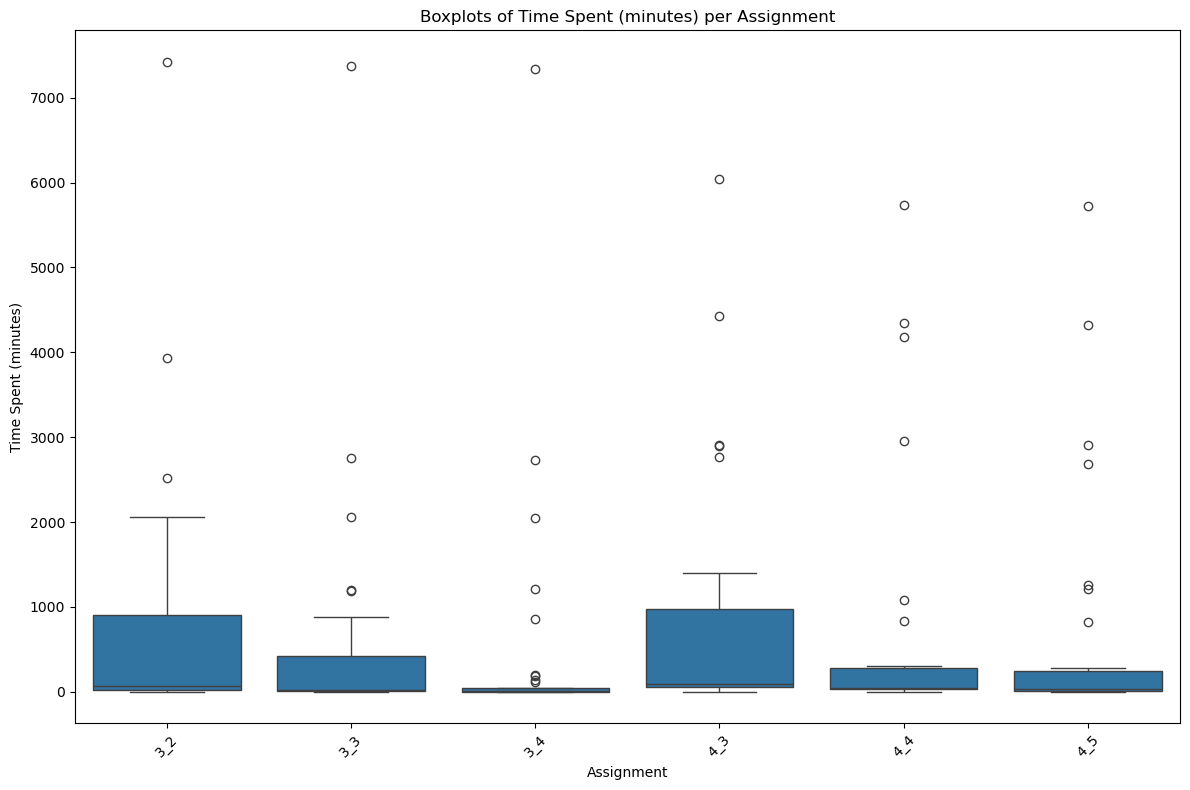

In [136]:
sorted_query_names = sorted(Query_time_overview['Query Name'].unique(), key=lambda x: [int(i) for i in x.split('_')])

plt.figure(figsize=(12, 8))
sns.boxplot(
    x='Query Name',
    y='Time Spent (minutes)',
    data=Query_time_overview,
    order=sorted_query_names 
)
plt.title('Boxplots of Time Spent (minutes) per Assignment')
plt.xlabel('Assignment')
plt.ylabel('Time Spent (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [137]:
# Boxplot-statistieken (inclusief mediaan = 50%)
boxplot_stats = Query_time_overview.groupby('Query Name')['Time Spent (minutes)'].describe()

# Hernoem kolom voor duidelijkheid
boxplot_stats = boxplot_stats.rename(columns={'50%': 'Mediaan (min)'})

# Bereken outliers
outlier_counts = []

for query_name, group in Query_time_overview.groupby('Query Name'):
    q1 = group['Time Spent (minutes)'].quantile(0.25)
    q3 = group['Time Spent (minutes)'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = group[(group['Time Spent (minutes)'] < lower_bound) | (group['Time Spent (minutes)'] > upper_bound)]
    
    outlier_counts.append({
        'Query Name': query_name,
        'Outlier Count': len(outliers),
        'Outlier %': (len(outliers) / len(group)) * 100
    })

outlier_df = pd.DataFrame(outlier_counts)

# Combineer alles
boxplot_stats = boxplot_stats.reset_index()
combined_df = pd.merge(boxplot_stats, outlier_df, on='Query Name')

# Sorteer op de juiste volgorde
combined_df = combined_df.set_index('Query Name').loc[sorted_query_names].reset_index()

# Optioneel: afronden voor leesbaarheid
pd.set_option('display.float_format', '{:.2f}'.format)

# ✅ Toon eindresultaat
display(combined_df)


,Query Name,count,mean,std,min,25%,Mediaan (min),75%,max,Outlier Count,Outlier %
0,3_2,41.00,685.43,1363.39,0.00,16.93,69.42,900.63,7423.45,3,7.32
1,3_3,41.00,481.33,1255.25,0.00,6.48,16.77,423.25,7372.90,5,12.20
2,3_4,40.00,377.73,1262.03,0.00,0.87,9.11,40.60,7339.73,9,22.50
3,4_3,32.00,803.75,1460.78,0.10,62.54,91.60,978.22,6045.12,5,15.62
4,4_4,29.00,719.03,1524.83,0.00,32.28,50.30,285.48,5733.00,6,20.69
5,4_5,30.00,666.60,1411.21,0.00,6.91,32.57,246.78,5723.73,7,23.33


In [17]:
outliers_dict = {}

for query_name, group in Query_time_overview.groupby('Query Name'):
    q1 = group['Time Spent (seconds)'].quantile(0.25)
    q3 = group['Time Spent (seconds)'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = group[(group['Time Spent (seconds)'] < lower_bound) | (group['Time Spent (seconds)'] > upper_bound)]

    outliers_dict[query_name] = outliers.reset_index(drop=True)

display(outliers_dict['3_2'])


,Query Name,File,Time Spent (seconds)
0,3_2,pp43.py,445407.00
1,3_2,pp18.py,151203.00
2,3_2,pp32.py,236246.00


**Stacked Bar Chart 1:**
Below, I have created a stacked bar chart that visually represents the distribution of different error types across each assignment (Query Name). Each bar corresponds to a specific assignment, and the segments within the bar indicate the proportion of each error type. This chart provides a clear overview of which assignments are more prone to specific types of errors and how frequently these errors occur.

For example, if a particular assignment shows a large segment of Syntax Errors, it may indicate that students struggle with the syntax of that specific query. This could suggest a need for better guidance on SQL syntax rules or more practice with similar queries. On the other hand, a high proportion of Logic Errors might suggest that the underlying logic of the query is challenging for students to grasp, potentially requiring additional explanations or examples to clarify the concepts.

Assignments with a significant portion of No Error indicate that students were able to execute the queries successfully, which could reflect a better understanding of the material or a lower level of difficulty for those specific tasks. By analyzing these distributions, we can identify patterns in student performance and tailor teaching strategies to address the most common challenges. This visual representation not only highlights the areas where students struggle the most but also helps in refining the assignments to improve learning outcomes.

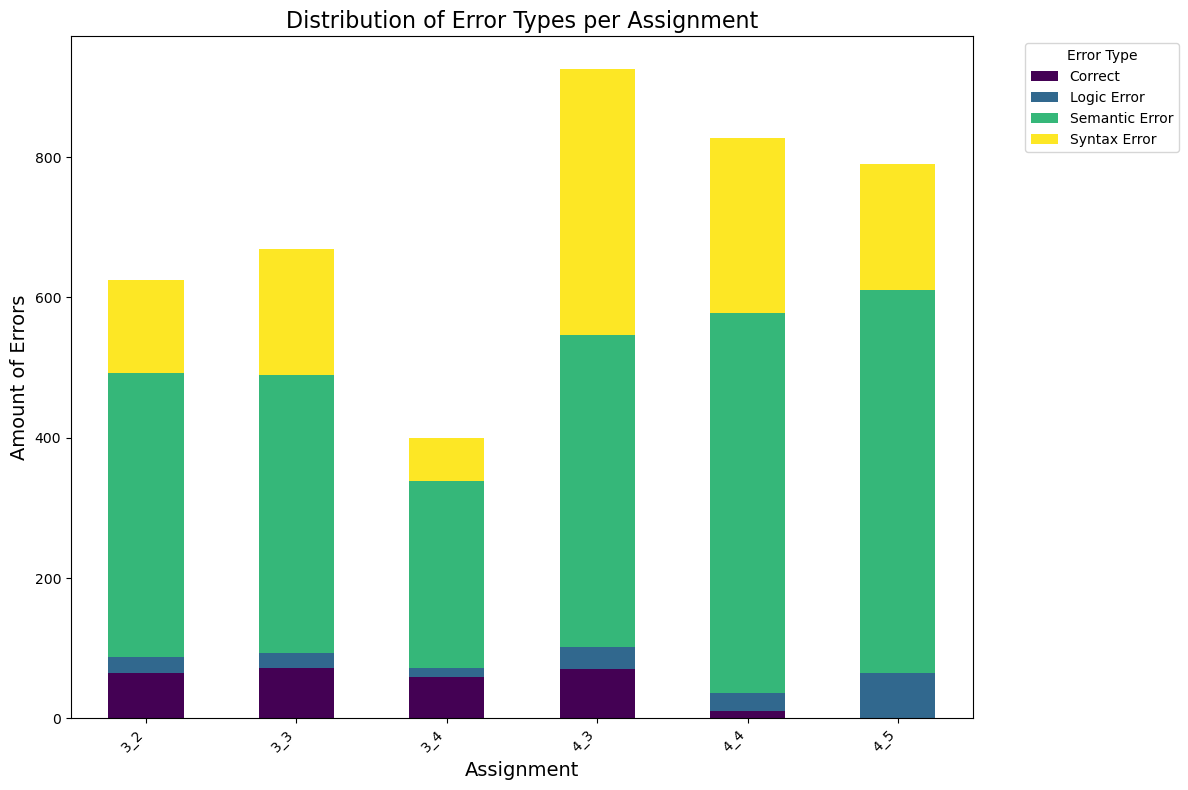

In [30]:
error_counts = Query_correct.groupby(['Query Name', 'New Error Type']).size().unstack(fill_value=0)

error_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')

plt.title('Distribution of Error Types per Assignment', fontsize=16)
plt.xlabel('Assignment', fontsize=14)
plt.ylabel('Amount of Errors', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Draai de x-as labels voor betere leesbaarheid
plt.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()

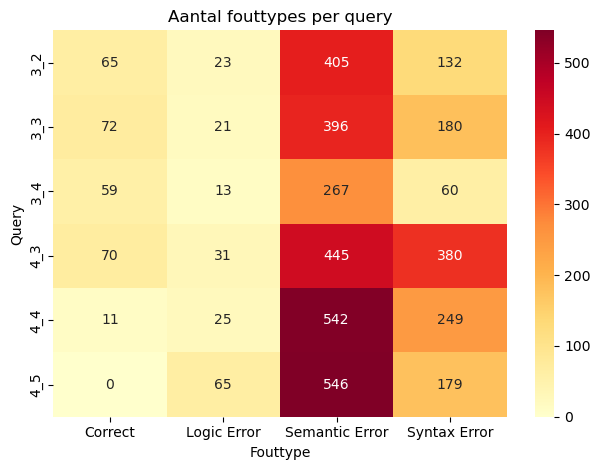

In [117]:
sns.heatmap(df_plot, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title("Aantal fouttypes per query")
plt.ylabel("Query")
plt.xlabel("Fouttype")
plt.tight_layout()
plt.show()


In [140]:
df = Query_correct.copy()

# Groepeer op Query Name en Error Type
df_counts = df.groupby(['Query Name', 'New Error Type']).size().reset_index(name='Aantal')

# Brede tabel
df_plot = df_counts.pivot(index='Query Name', columns='New Error Type', values='Aantal').fillna(0).astype(int)

# Voeg totaal kolommen toe als ze bestaan
for col in ['Correct', 'Syntax Error', 'Logic Error', 'Semantic Error']:
    if col not in df_plot.columns:
        df_plot[col] = 0  # Voeg toe als kolom ontbreekt

df_plot.loc['Totaal over alle queries'] = df_plot.sum()

# Voeg totaal inclusief correcte antwoorden toe
df_plot['Totaal Pogingen'] = df_plot[['Correct', 'Syntax Error', 'Logic Error', 'Semantic Error']].sum(axis=1)

# Bekijk resultaat
display(df_plot)


New Error Type,Correct,Logic Error,Semantic Error,Syntax Error,Totaal Pogingen
Query Name,,,,,
3_2,65,23,405,132,625
3_3,72,21,396,180,669
3_4,59,13,267,60,399
4_3,70,31,445,380,926
4_4,11,25,542,249,827
4_5,0,65,546,179,790
Totaal over alle queries,277,178,2601,1180,4236


In [158]:
Uniek_correct = duckdb.query('''
    select "Query Name", count(File) as Aantal
    from (
    SELECT distinct "Query Name", File
    FROM Query_correct AS df
    where correct = 2) as A
    group by "Query Name"
    order by "Query Name" asc
''').to_df()

# Bereken de totaalsom van alleen de kolom 'Aantal'
totaal = Uniek_correct['Aantal'].sum()

# Voeg een nieuwe rij toe met alleen de som in de juiste kolom
Uniek_correct.loc[len(Uniek_correct)] = ["Totaal over alle queries", totaal]

# Display zonder index
display(Uniek_correct)


,Query Name,Aantal
0,3_2,19
1,3_3,14
2,3_4,17
3,4_3,16
4,4_4,4
5,Totaal over alle queries,70


**Boxplot 2:**
Additionally, I have included a boxplot to provide a deeper understanding of the distribution of query executions per assignment. Each boxplot represents a specific assignment (Query Name), and the y-axis shows the number of times each query was executed by students. This visualization helps to quickly identify both general patterns and anomalies in student behavior.

To support this visual analysis, I also calculated descriptive statistics for each assignment. For example, assignment 4_5 had the highest maximum number of executions (222) and also one of the highest percentages of outliers (10%). In contrast, assignments 3_2 and 4_4 had no detected outliers, indicating more consistent performance across students. Assignment 3_3 had 4 outliers, which represents nearly 10% of all attempts for that query, pointing to a few students who may have struggled with it.

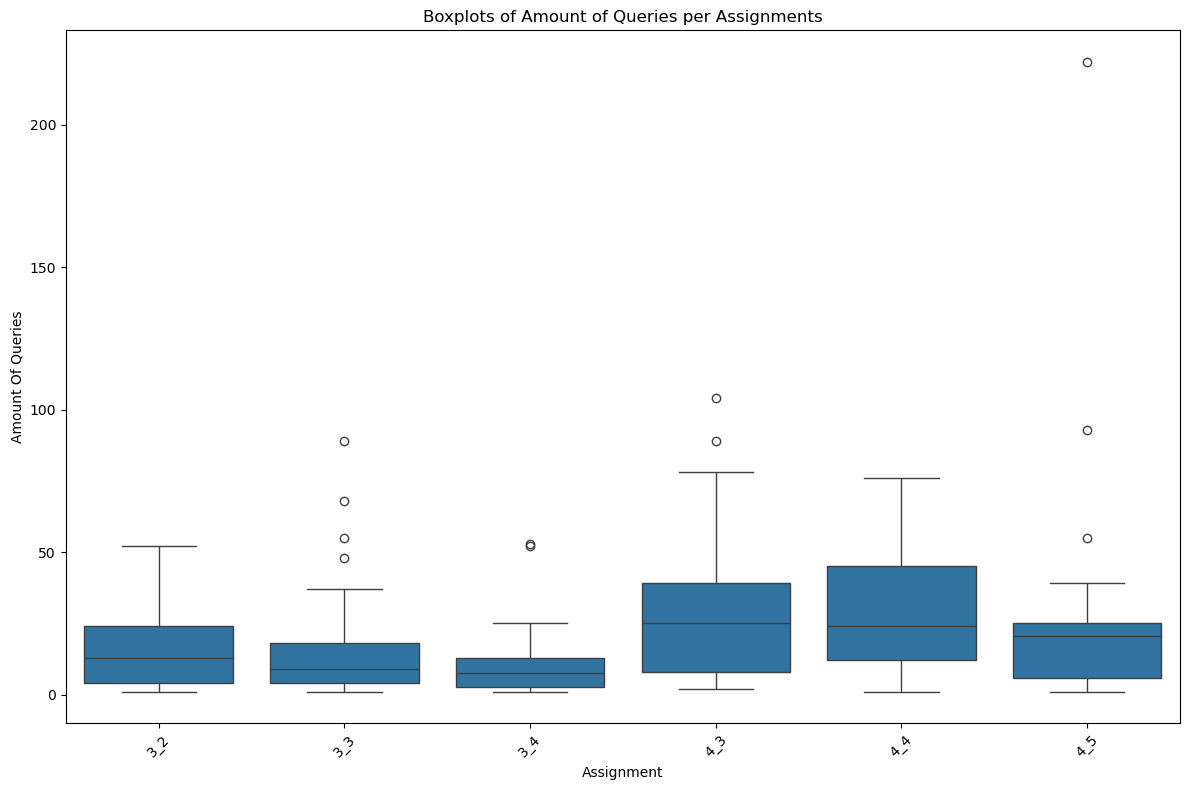

In [31]:
plt.figure(figsize=(12, 8))  
sns.boxplot(
    x='Query Name',  
    y='Amount_Of_Queries',  
    data=Query_Amount_Overview  
)
plt.title('Boxplots of Amount of Queries per Assignments')  
plt.xlabel('Assignment')  
plt.ylabel('Amount Of Queries')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [173]:
boxplot_stats = Query_Amount_Overview.groupby('Query Name')['Amount_Of_Queries'].describe()

outlier_counts = []

for query_name, group in Query_Amount_Overview.groupby('Query Name'):
    q1 = group['Amount_Of_Queries'].quantile(0.25)
    q3 = group['Amount_Of_Queries'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = group[(group['Amount_Of_Queries'] < lower_bound) | (group['Amount_Of_Queries'] > upper_bound)]
    
    outlier_counts.append({
        'Query Name': query_name,
        'Outlier Count': len(outliers),
        'Outlier %': (len(outliers) / len(group)) * 100
    })

outlier_df = pd.DataFrame(outlier_counts)

boxplot_stats = boxplot_stats.reset_index()

combined_df = pd.merge(boxplot_stats, outlier_df, on='Query Name')

combined_df = combined_df.set_index('Query Name').loc[sorted_query_names].reset_index()

pd.set_option('display.float_format', '{:.2f}'.format)
display(combined_df)


,Query Name,count,mean,std,min,25%,50%,75%,max,Outlier Count,Outlier %
0,3_2,41.00,15.24,12.95,1.00,4.00,13.00,24.00,52.00,0,0.00
1,3_3,41.00,16.32,19.27,1.00,4.00,9.00,18.00,89.00,4,9.76
2,3_4,40.00,9.97,11.80,1.00,2.75,7.50,13.00,53.00,2,5.00
3,4_3,32.00,28.94,26.40,2.00,8.00,25.00,39.25,104.00,2,6.25
4,4_4,29.00,28.52,21.01,1.00,12.00,24.00,45.00,76.00,0,0.00
5,4_5,30.00,26.33,41.42,1.00,6.00,20.50,25.00,222.00,3,10.00


In [33]:
outliers_dict = {}

for query_name, group in Query_Amount_Overview.groupby('Query Name'):
    q1 = group['Amount_Of_Queries'].quantile(0.25)
    q3 = group['Amount_Of_Queries'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = group[(group['Amount_Of_Queries'] < lower_bound) | (group['Amount_Of_Queries'] > upper_bound)]

    outliers_dict[query_name] = outliers.reset_index(drop=True)

display(outliers_dict['3_3'])


,Query Name,File,Amount_Of_Queries
0,3_3,pp41.py,68
1,3_3,pp1.py,55
2,3_3,pp15.py,48
3,3_3,pp27.py,89


To gain a deeper understanding of the relationships between different types of features in my dataset, I created a correlation matrix. This matrix provides a comprehensive overview of how each feature correlates with the others, helping me identify potential patterns, dependencies, or redundancies in the data.

The correlation matrix is particularly useful for guiding further analysis. For example, by examining the correlation coefficients, I can determine which features are strongly related and which are independent. This allows me to focus on specific relationships that may be worth exploring in more detail. Based on the insights from the correlation matrix, I can create targeted scatterplots to visualize the distribution of data points and identify any outliers or unusual patterns. These scatterplots provide a more granular view of the relationships between features, helping me to better understand the underlying structure of the data.

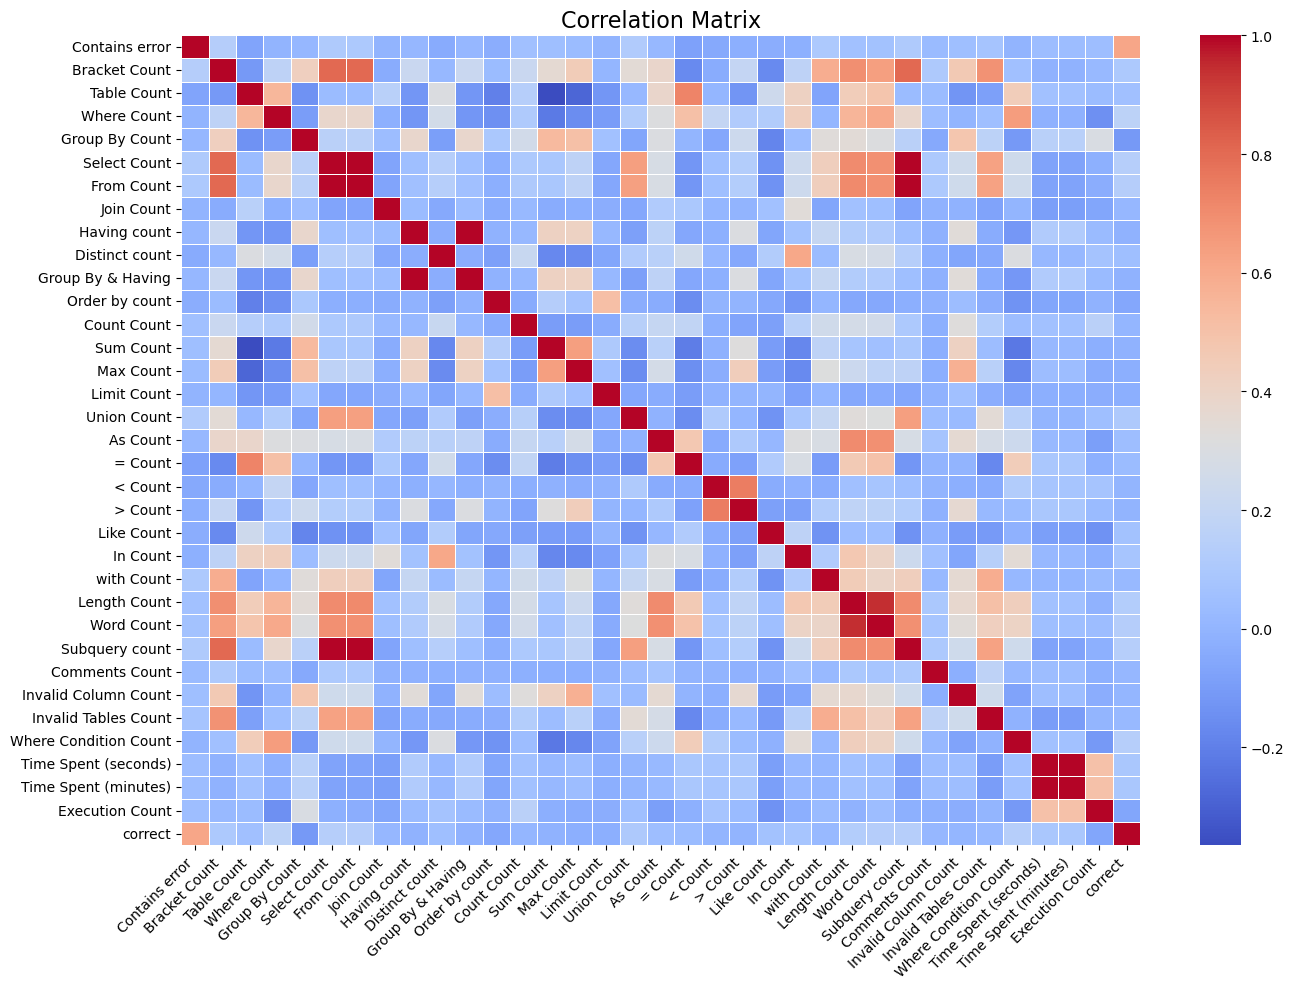

In [94]:
correlation_matrix = Query_correct .corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



**Description of the Scatterplots:**
To understand the relationships between different variables in my dataset, I created a series of scatterplots. These visualizations help me identify patterns, trends, and outliers, which are essential. Below, I discuss each of the scatterplots and the insights they provide.
 
 1. Word Count vs Length Count: 
This scatterplot examines the relationship between the number of words (Word Count) and the total length of the query (Length Count). Overall, I observe a positive trend: queries with more words also have a greater total length. This makes sense, as more words typically result in a longer query. However, there are some outliers. Queries with a high Word Count but a low Length Count might indicate queries with many short words, while queries with a low Word Count but a high Length Count could contain many long words or special characters. These insights help me understand how the structure of the queries varies.

2. Execution Count vs Time Spent (seconds):
This scatterplot shows the relationship between the number of times a query was executed (Execution Count) and the time spent on the query (Time Spent (seconds)). I notice a slight positive trend, suggesting that queries executed more frequently generally take more time. This could indicate more complex queries that require multiple attempts. However, there are some interesting outliers. Queries with a high Execution Count but a low Time Spent (seconds) might represent queries that are executed quickly but repeated often, possibly due to errors. On the other hand, queries with a low Execution Count but a high Time Spent (seconds) could be complex queries that take a lot of time but are executed less frequently.

3. Bracket Count vs Select Count:
This scatterplot explores the relationship between the number of brackets (Bracket Count) and the number of SELECT statements (Select Count) in a query. I see a clear positive trend: queries with more SELECT statements also contain more brackets. This is likely due to the use of nested subqueries. However, there are some exceptions. Queries with a high Bracket Count but a low Select Count might indicate complex conditions in WHERE clauses, while queries with a low Bracket Count but a high Select Count could be simple queries without nested subqueries.


4. Bracket Count vs Invalid Tables Count:
This scatterplot examines the relationship between the number of brackets (Bracket Count) and the number of invalid tables (Invalid Tables Count) in a query. I observe a weak positive trend, suggesting that queries with more brackets also tend to have slightly more invalid tables. This could indicate complex queries that contain errors. However, there are some interesting outliers. Queries with a high Bracket Count but a low Invalid Tables Count might be complex but correctly written queries, while queries with a low Bracket Count but a high Invalid Tables Count could be simple queries with errors, such as incorrect table names.

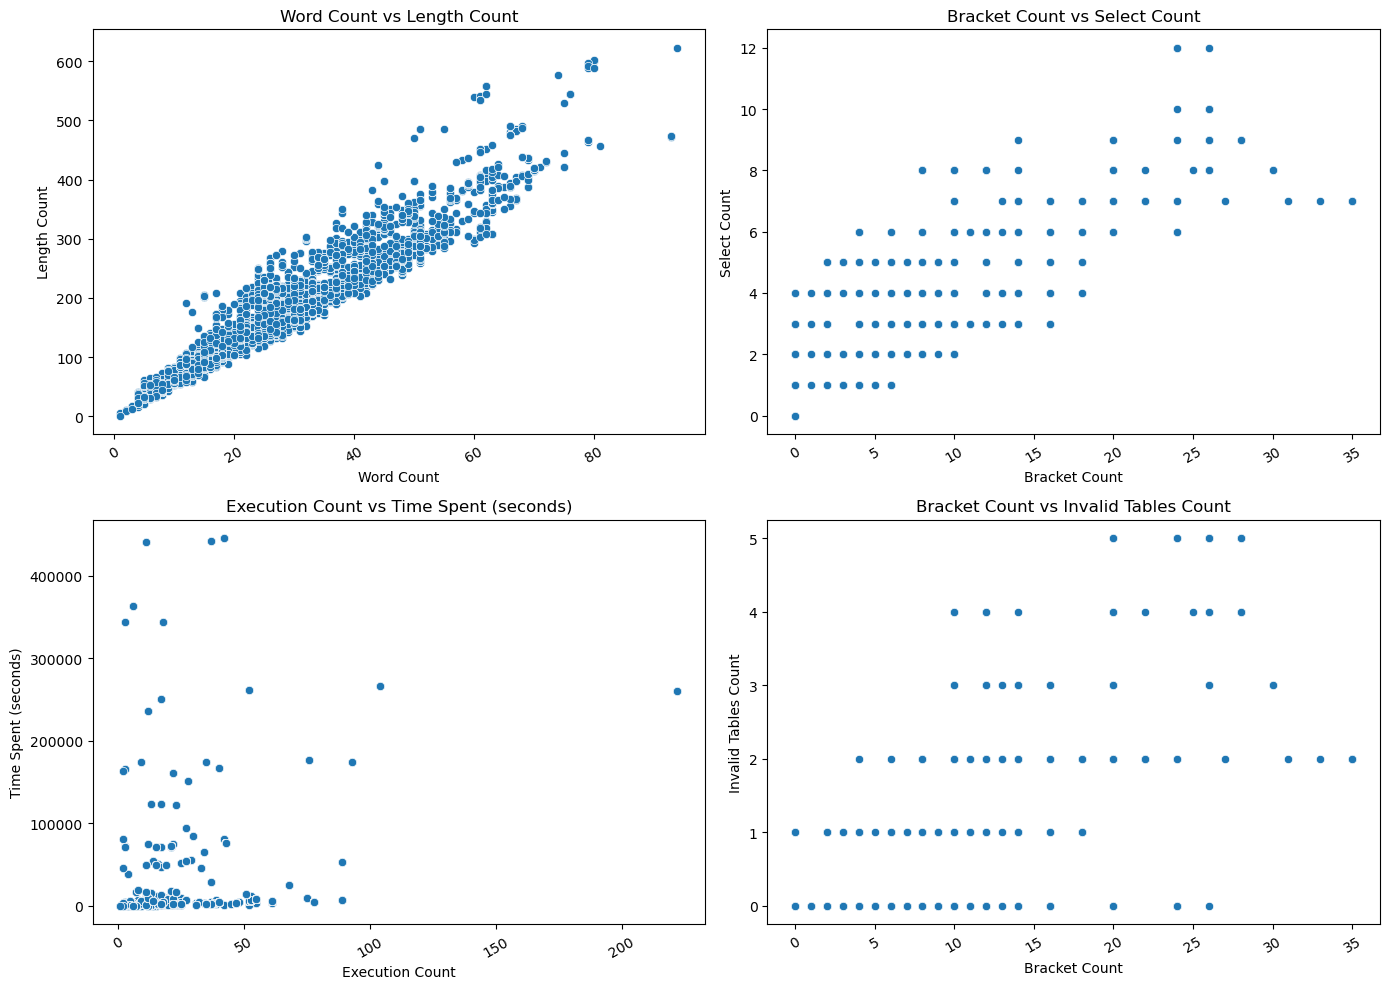

In [35]:
scatter_pairs = [
    ('Word Count', 'Length Count'),
    ('Bracket Count', 'Select Count'),
    ( 'Execution Count', 'Time Spent (seconds)'),
    ('Bracket Count', 'Invalid Tables Count')
]

# Maak een 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  

axes = axes.flatten()

for i, (x_col, y_col) in enumerate(scatter_pairs):
    sns.scatterplot(x=x_col, y=y_col, data=queries_df, ax=axes[i])
    axes[i].set_title(f'{x_col} vs {y_col}')
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


 Analyseren voor: Semantic Error


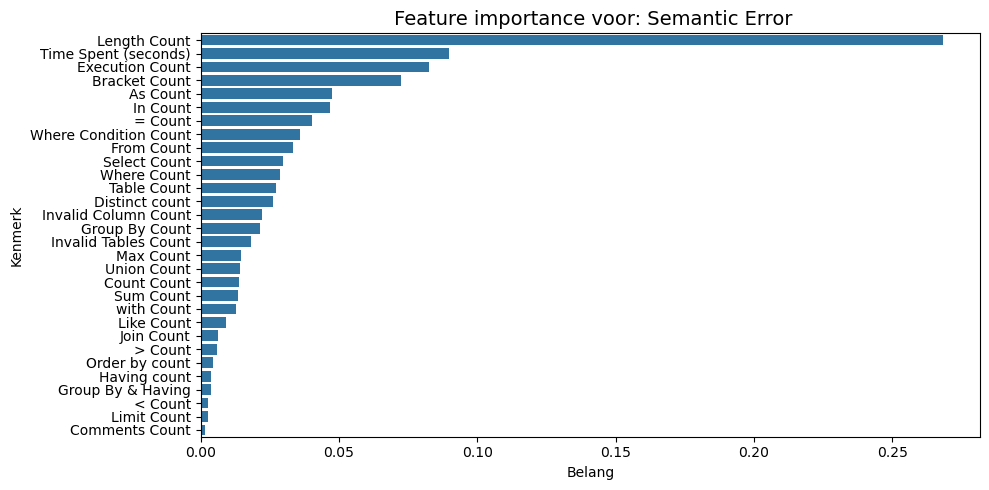


 Analyseren voor: Syntax Error


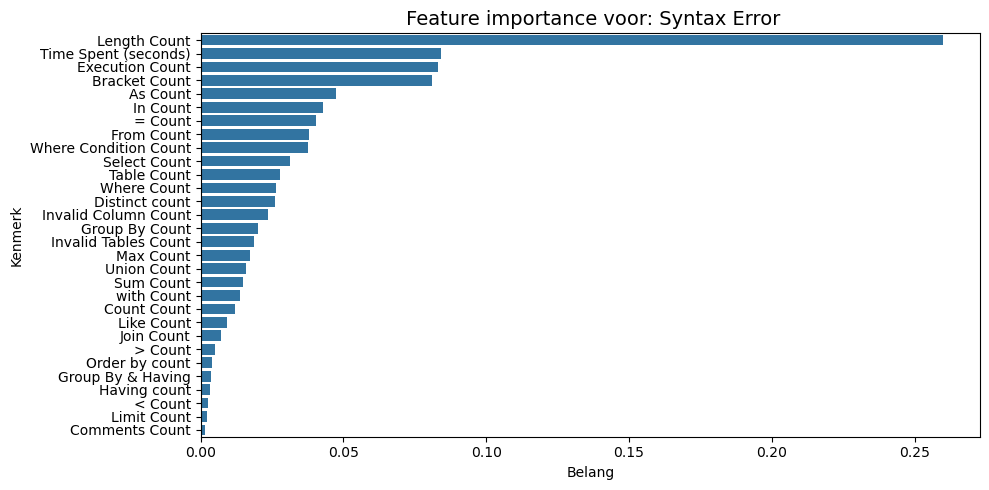


 Analyseren voor: Logic Error


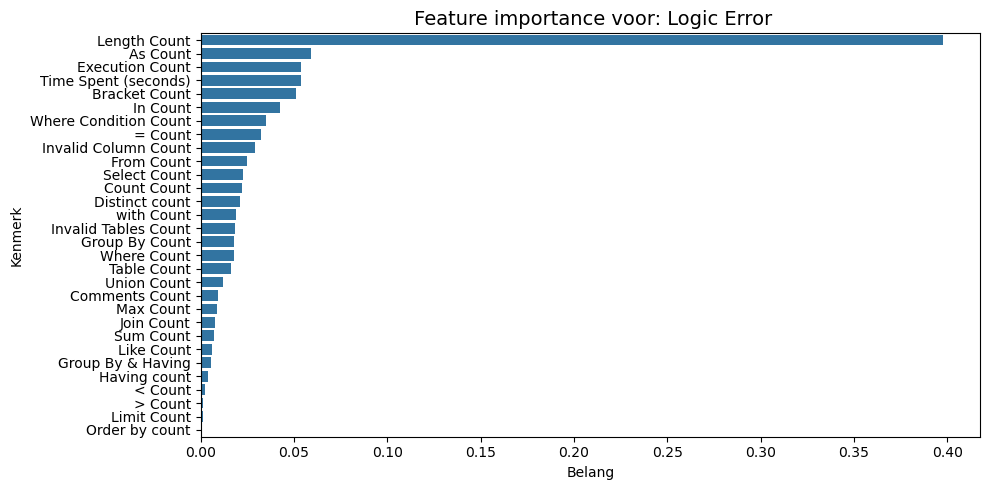


 Analyseren voor: Correct


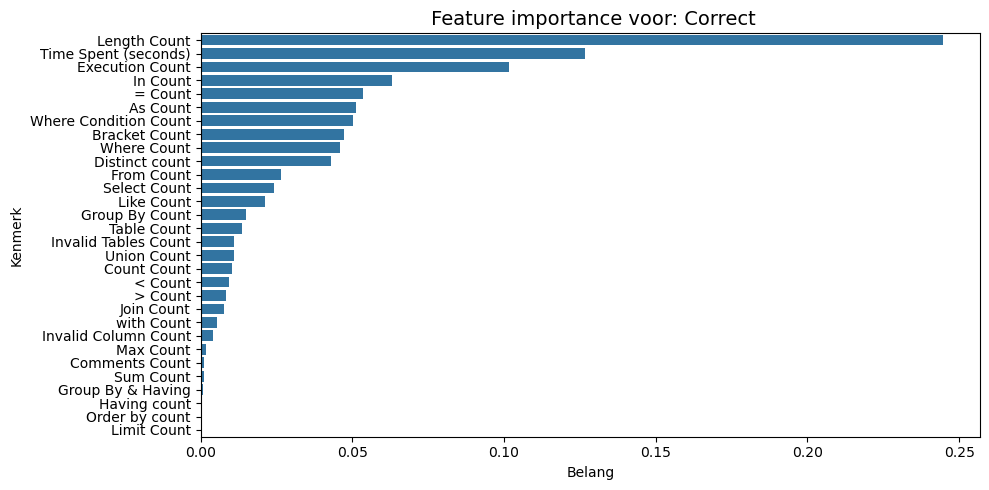

In [49]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Kopie van het dataframe
df = Query_correct.copy()

# Alle unieke fouttypes ophalen
error_types = df['New Error Type'].dropna().unique()

# Selecteer numerieke kolommen
numeric_features = df.select_dtypes(include='number').columns.tolist()

# Verwijder ongewenste kolommen als ze bestaan
for col in ['Contains error', 'Error Type Encoded', 'correct', 'Error Message','Error Type', 'Time Spent (minutes)', 'Word Count', 'Subquery count']:
    if col in numeric_features:
        numeric_features.remove(col)

# Resultaat opslaan
importances_per_error = {}

# Per error type analyseren
for error in error_types:
    print(f"\n Analyseren voor: {error}")
  
    # Binaire target maken: is deze error of niet?
    df['target'] = (df['New Error Type'] == error).astype(int)
    
    X = df[numeric_features]
    y = df['target']
    
    # Random forest model trainen
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)

    # Feature importance ophalen
    importances = model.feature_importances_
    importances_per_error[error] = dict(zip(X.columns, importances))
    
    # Visualiseren
    sorted_idx = importances.argsort()[::-1]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=importances[sorted_idx], y=X.columns[sorted_idx])
    plt.title(f' Feature importance voor: {error}', fontsize=14)
    plt.xlabel('Belang')
    plt.ylabel('Kenmerk')
    plt.tight_layout()
    plt.show()



In [146]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Dataframe kopiëren
df = Query_correct.copy()

# Alle unieke fouttypes
error_types = df['New Error Type'].dropna().unique()

# Selecteer numerieke features
numeric_features = df.select_dtypes(include='number').columns.tolist()
for col in ['Contains error', 'Error Type Encoded', 'correct', 'Error Message', 'Error Type', 
            'Time Spent (minutes)', 'Word Count', 'Subquery count']:
    if col in numeric_features:
        numeric_features.remove(col)

# Resultaat opslaan per error type
top_features_per_error = {}

for error in error_types:
    # Binaire target maken
    df['target'] = (df['New Error Type'] == error).astype(int)
    
    X = df[numeric_features]
    y = df['target']
    
    # Model trainen
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    
    # Feature importance ophalen en sorteren
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(10).reset_index(drop=True)
    
    # Opslaan in dictionary
    top_features_per_error[error] = feature_importance_df

for error_type, df_feat in top_features_per_error.items():
    print(f"\nTop  10 features voor fouttype: {error_type}")
    display(df_feat)




Top  10 features voor fouttype: Semantic Error


,Feature,Importance
0,Length Count,0.27
1,Time Spent (seconds),0.09
2,Execution Count,0.08
3,Bracket Count,0.07
4,As Count,0.05
5,In Count,0.05
6,= Count,0.04
7,Where Condition Count,0.04
8,From Count,0.03
9,Select Count,0.03



Top  10 features voor fouttype: Syntax Error


,Feature,Importance
0,Length Count,0.26
1,Time Spent (seconds),0.08
2,Execution Count,0.08
3,Bracket Count,0.08
4,As Count,0.05
5,In Count,0.04
6,= Count,0.04
7,From Count,0.04
8,Where Condition Count,0.04
9,Select Count,0.03



Top  10 features voor fouttype: Logic Error


,Feature,Importance
0,Length Count,0.40
1,As Count,0.06
2,Execution Count,0.05
3,Time Spent (seconds),0.05
4,Bracket Count,0.05
5,In Count,0.04
6,Where Condition Count,0.03
7,= Count,0.03
8,Invalid Column Count,0.03
9,From Count,0.03



Top  10 features voor fouttype: Correct


,Feature,Importance
0,Length Count,0.24
1,Time Spent (seconds),0.13
2,Execution Count,0.10
3,In Count,0.06
4,= Count,0.05
5,As Count,0.05
6,Where Condition Count,0.05
7,Bracket Count,0.05
8,Where Count,0.05
9,Distinct count,0.04


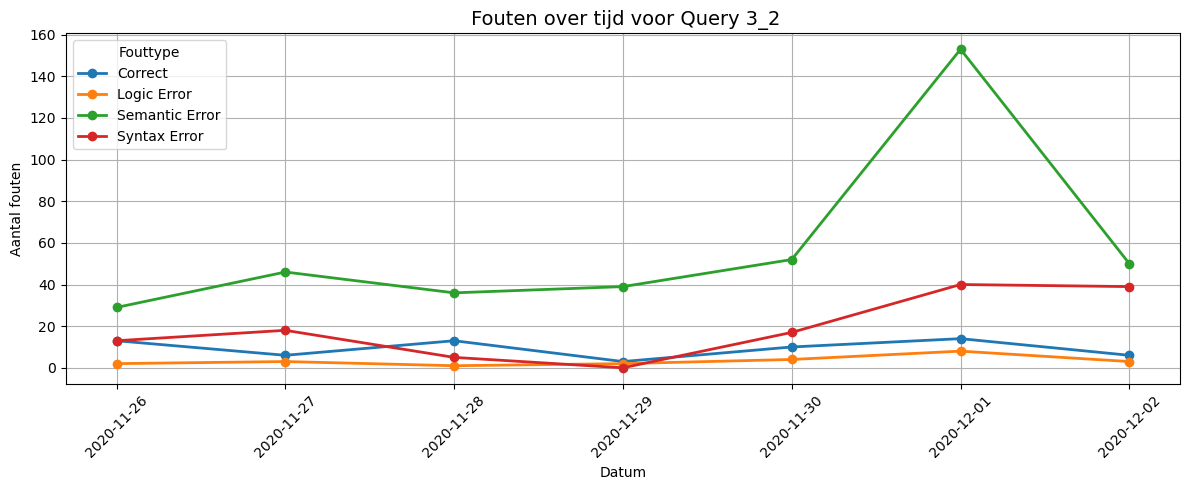

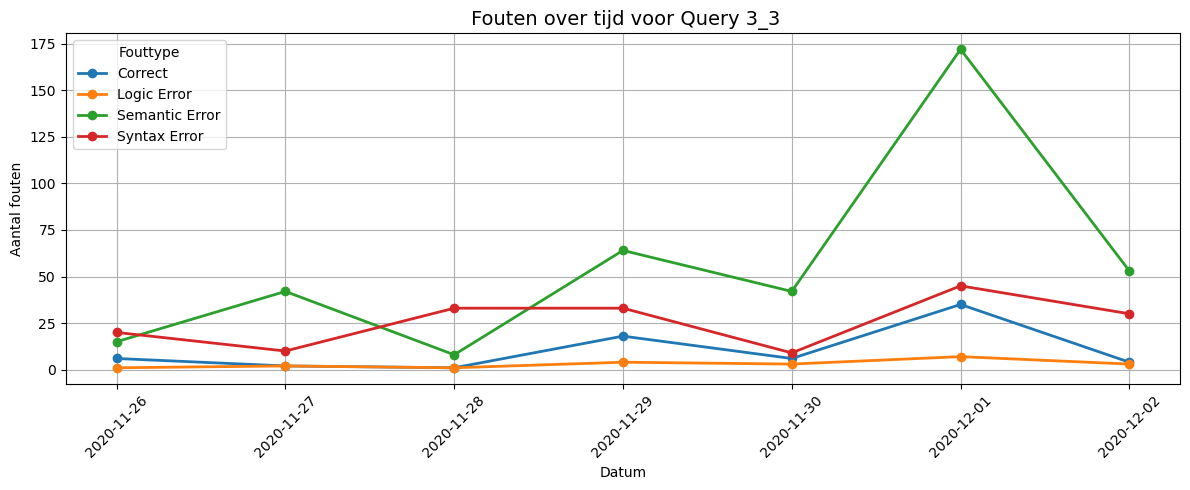

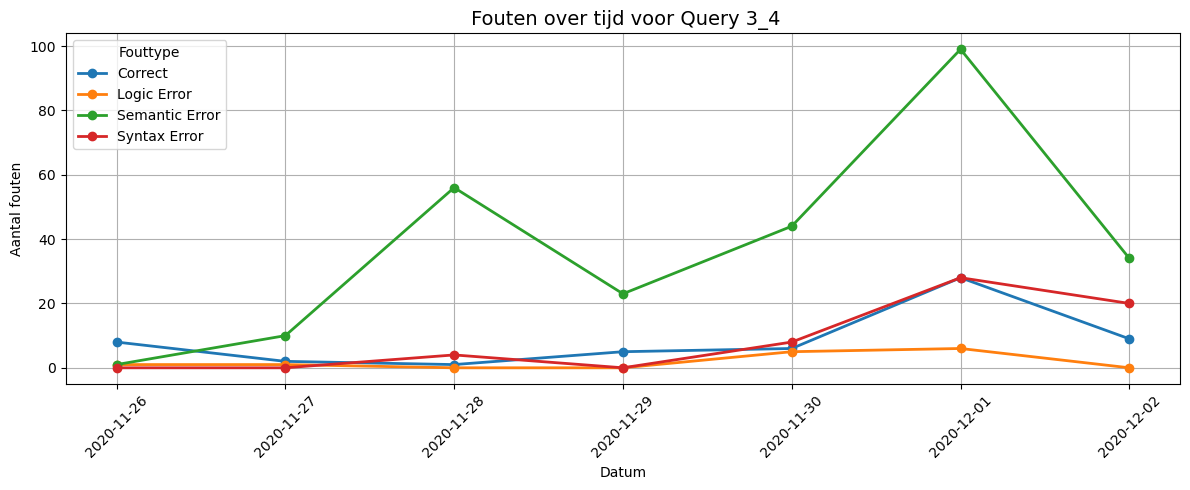

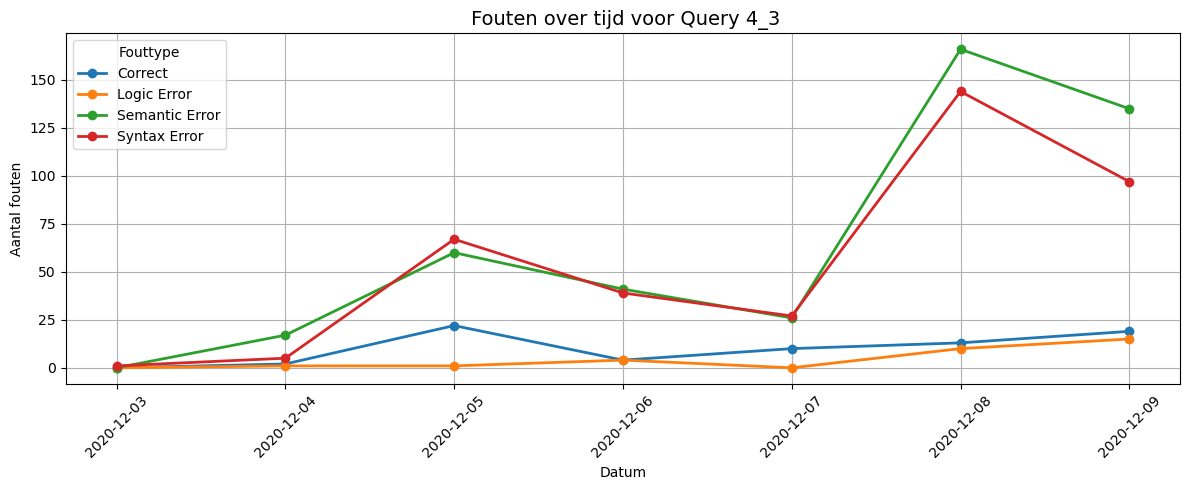

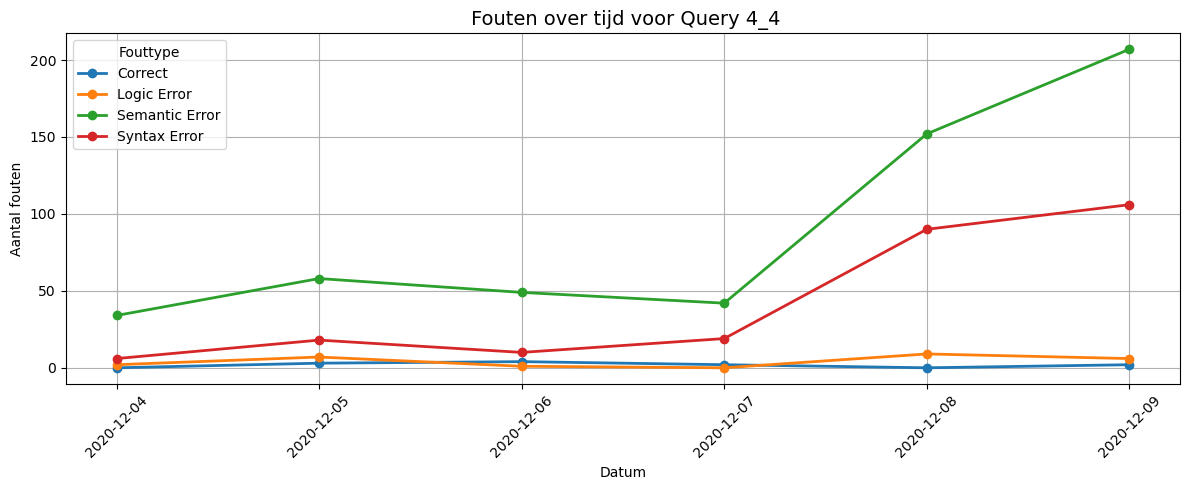

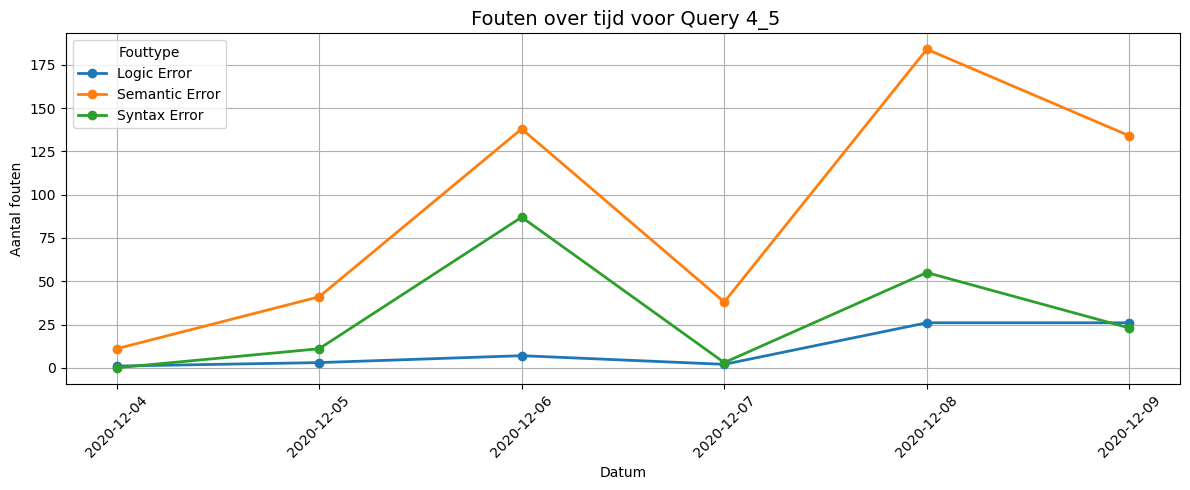

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Kopie en datums klaarmaken
df = Query_correct.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Date'] = df['Timestamp'].dt.date  # alleen de datum

# Groepeer per Query Name, Date en Error Type
error_trend = (
    df.groupby(['Query Name', 'Date', 'New Error Type'])
    .size()
    .reset_index(name='Count')
)

# Loop door elke unieke query en plot foutontwikkeling
for query in error_trend['Query Name'].unique():
    subset = error_trend[error_trend['Query Name'] == query]

    # Pivot zodat elke Error Type een eigen lijn wordt
    pivot_df = subset.pivot(index='Date', columns='New Error Type', values='Count').fillna(0)

    plt.figure(figsize=(12, 5))
    pivot_df.plot(kind='line', marker='o', linewidth=2, ax=plt.gca())

    plt.title(f" Fouten over tijd voor Query {query}", fontsize=14)
    plt.xlabel("Datum")
    plt.ylabel("Aantal fouten")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Fouttype")
    plt.tight_layout()
    plt.show()


**Aantal fouten per student en verdeling van fouttypes**

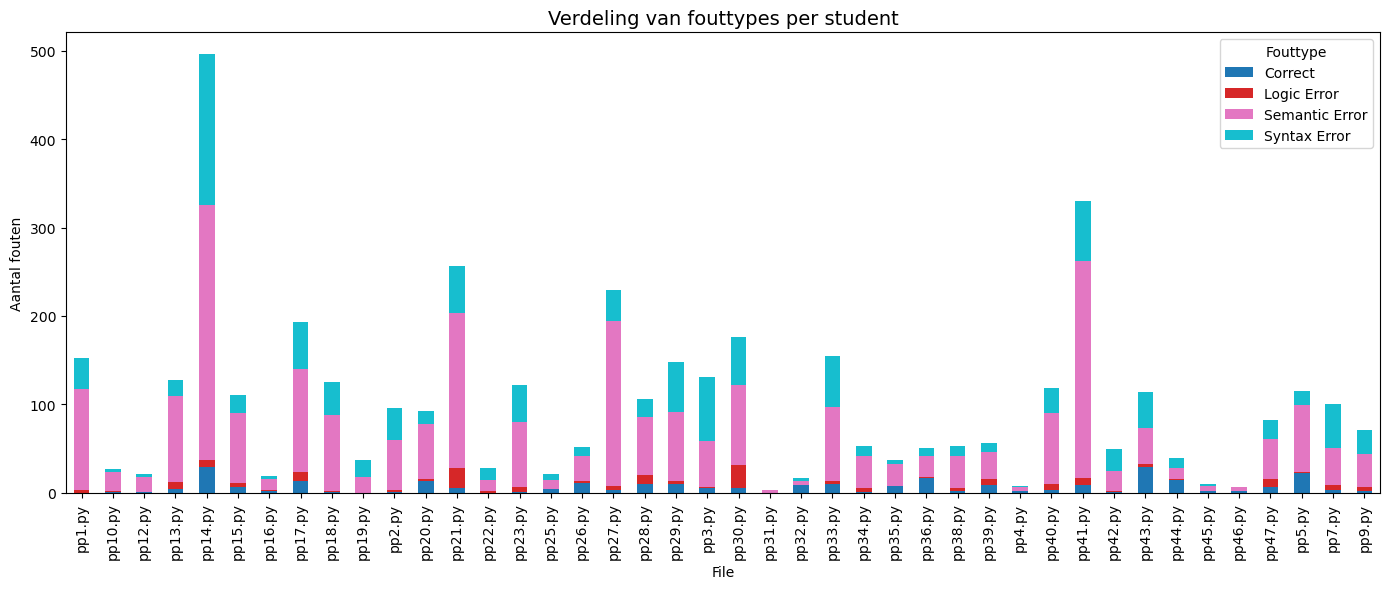

In [86]:
# Aantal fouten per fouttype per student
errors_by_type = df.groupby(['File', 'New Error Type']).size().unstack(fill_value=0)

# Plot
errors_by_type.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab10')
plt.title("Verdeling van fouttypes per student", fontsize=14)
plt.ylabel("Aantal fouten")
plt.xticks(rotation=90)
plt.legend(title="Fouttype")
plt.tight_layout()
plt.show()


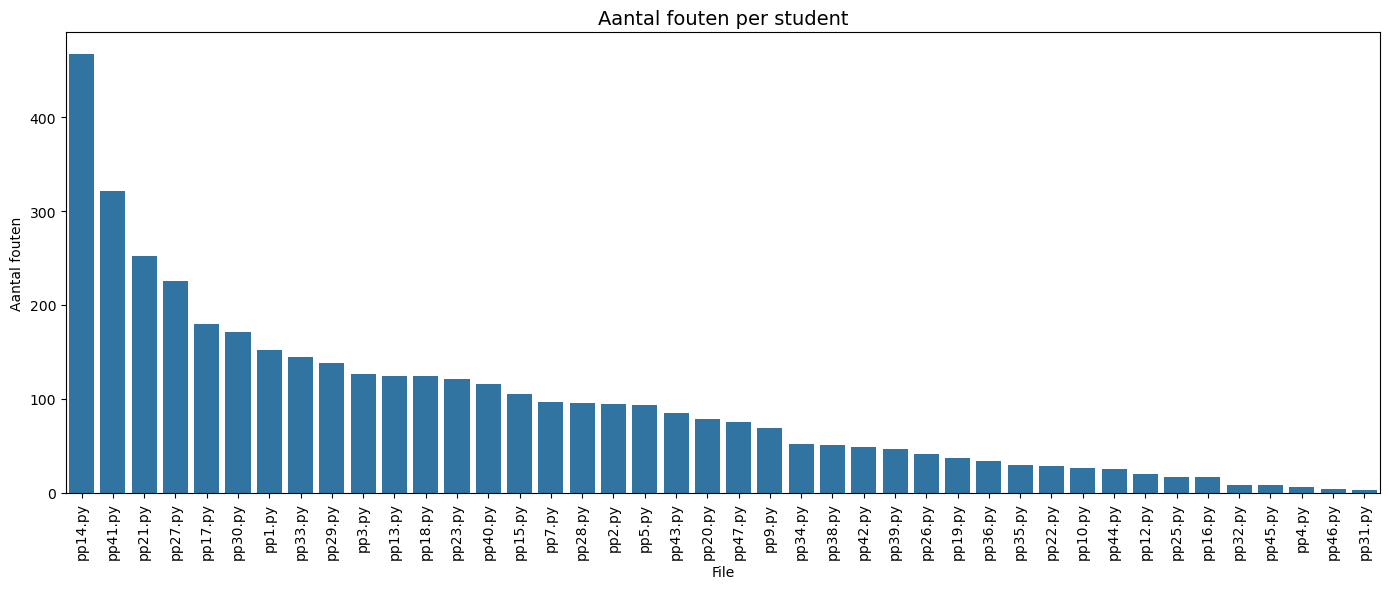

In [57]:
df = Query_correct.copy()

# Filter alleen rijen die fouten bevatten
df_errors = df[df['New Error Type'] != 'Correct']

# Aantal fouten per student
errors_per_student = df_errors['File'].value_counts().reset_index()
errors_per_student.columns = ['File', 'Aantal fouten']

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x='File', y='Aantal fouten', data=errors_per_student)
plt.title("Aantal fouten per student", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


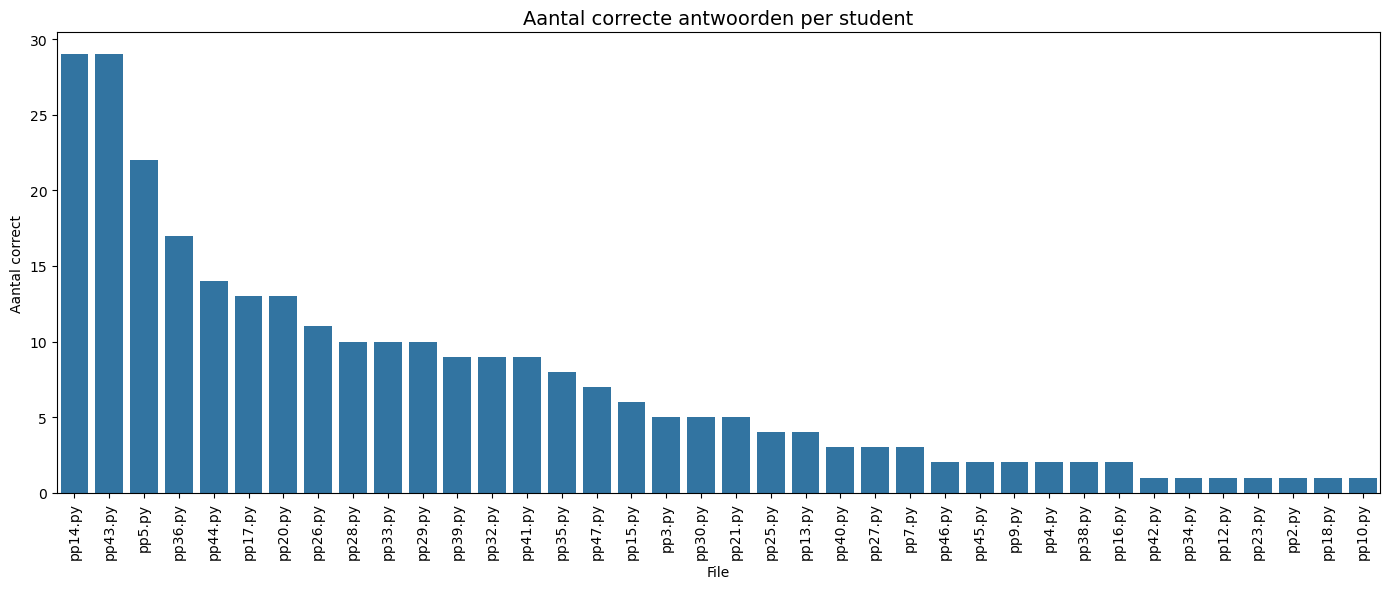

In [59]:
df = Query_correct.copy()

# Filter alleen rijen die fouten bevatten
df_errors = df[df['New Error Type'] == 'Correct']

# Aantal fouten per student
errors_per_student = df_errors['File'].value_counts().reset_index()
errors_per_student.columns = ['File', 'Aantal correct']

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x='File', y='Aantal correct', data=errors_per_student)
plt.title("Aantal correcte antwoorden per student", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


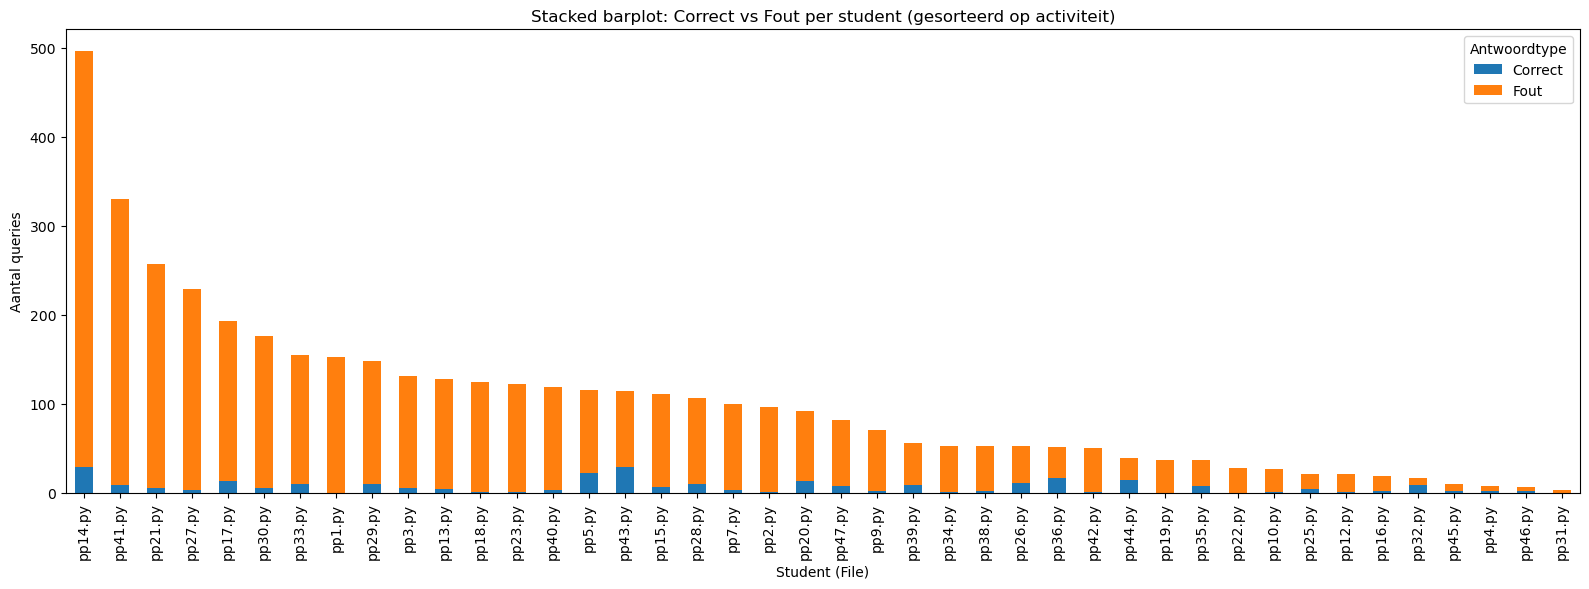

In [66]:
# Kopie maken
df = Query_correct.copy()

# Voeg een kolom toe: Correct of Fout
df['Correctness'] = df['New Error Type'].apply(lambda x: 'Correct' if x == 'Correct' else 'Fout')

# Groepeer op student (File) en Correctness
stacked_df = df.groupby(['File', 'Correctness']).size().unstack(fill_value=0)

# ➕ Sorteer op totaal aantal queries per student
stacked_df['Totaal'] = stacked_df.sum(axis=1)
stacked_df = stacked_df.sort_values('Totaal', ascending=False).drop(columns='Totaal')

stacked_df['Percentage correct'] = 100 * stacked_df['Correct'] / (stacked_df['Correct'] + stacked_df['Fout'])

# Plot
stacked_df[['Correct', 'Fout']].plot(kind='bar', stacked=True, figsize=(16, 6))
plt.title("Stacked barplot: Correct vs Fout per student (gesorteerd op activiteit)")
plt.ylabel("Aantal queries")
plt.xlabel("Student (File)")
plt.xticks(rotation=90)
plt.legend(title="Antwoordtype")
plt.tight_layout()
plt.show()


In [177]:
# Filter alleen correcte antwoorden
correct_df = df[df['correct'] == 2]

# Maak kruistabel: correcte antwoorden per student per query
pivot_table = pd.pivot_table(
    correct_df,
    values='Query',
    index='File',
    columns='Query Name',
    aggfunc='count',
    fill_value=0
)

# Totale correct antwoorden
pivot_table['Totaal Correct'] = pivot_table.sum(axis=1)

# Aantal unieke correcte queries
pivot_table['Unieke Queries Correct'] = (pivot_table.drop(columns='Totaal Correct') > 0).sum(axis=1)

# ✅ Percentage correct (van max 4 vragen)
pivot_table['Percentage Correct (Uniek)'] = 100 * pivot_table['Unieke Queries Correct'] / 5

# Sorteer
pivot_table = pivot_table.sort_values('Totaal Correct', ascending=False)

# Bekijk het resultaat
display(pivot_table)


Query Name,3_2,3_3,3_4,4_3,4_4,Totaal Correct,Unieke Queries Correct,Percentage Correct (Uniek)
File,,,,,,,,
pp14.py,9,0,0,16,4,29,3,60.00
pp43.py,7,11,11,0,0,29,3,60.00
pp5.py,0,13,5,2,2,22,4,80.00
pp36.py,0,8,9,0,0,17,2,40.00
pp44.py,0,10,4,0,0,14,2,40.00
pp17.py,2,6,0,5,0,13,3,60.00
pp20.py,3,0,1,6,3,13,4,80.00
pp26.py,0,6,5,0,0,11,2,40.00
pp28.py,0,0,3,5,2,10,3,60.00


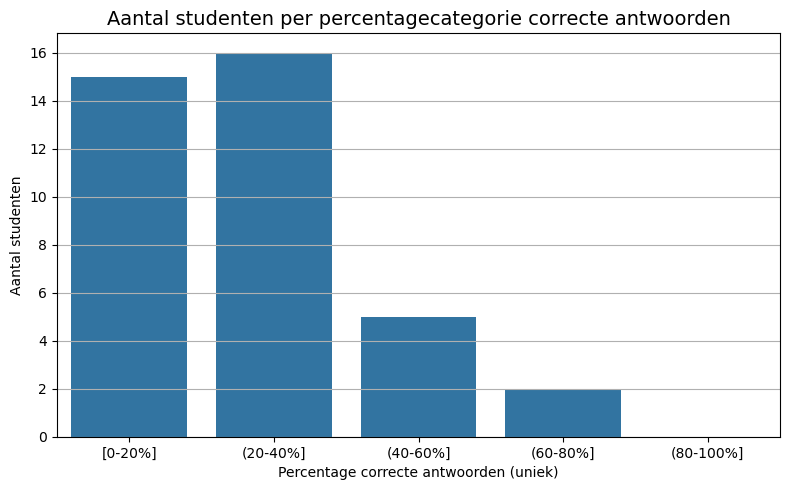

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Zorg dat de percentagekolom correct is afgerond (optioneel)
pivot_table['Percentage Rounded'] = pivot_table['Percentage Correct (Uniek)'].round()

# Groepeer in categorieën (je kunt dit aanpassen)
bins = [0, 20, 40, 60, 80, 100]
labels = ['[0-20%]', '(20-40%]', '(40-60%]', '(60-80%]', '(80-100%]']
pivot_table['Percentage Category'] = pd.cut(
    pivot_table['Percentage Correct (Uniek)'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Aantal studenten per percentageklasse
percentage_counts = pivot_table['Percentage Category'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=percentage_counts.index, y=percentage_counts.values)

plt.title("Aantal studenten per percentagecategorie correcte antwoorden", fontsize=14)
plt.xlabel("Percentage correcte antwoorden (uniek)")
plt.ylabel("Aantal studenten")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


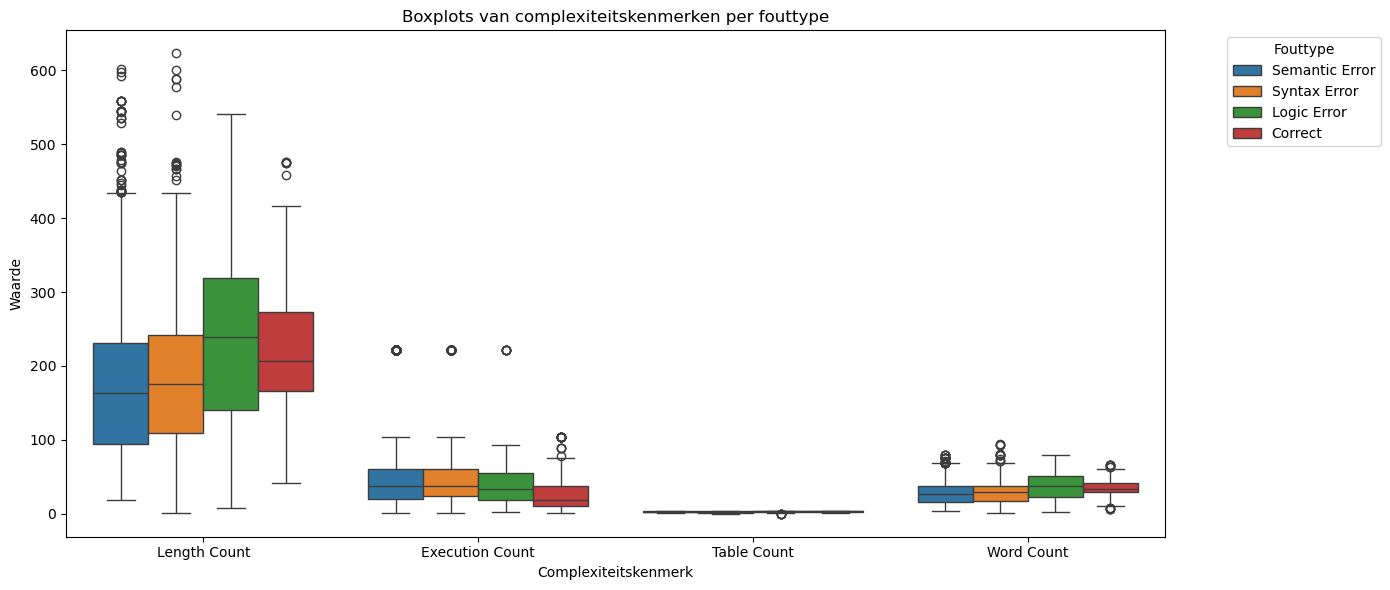

In [99]:
# Gebruik de bestaande DataFrame: df = Query_correct.copy()
df = Query_correct.copy()

# Kies de complexiteitskenmerken die bestaan
complexity_features = ['Length Count', 'Execution Count', 'Table Count', 'Word Count']

# Smelt de dataframe voor plotting
melted_df = df.melt(id_vars='New Error Type', value_vars=complexity_features,
                    var_name='Complexiteitskenmerk', value_name='Waarde')

# Maak de boxplots
plt.figure(figsize=(14, 6))
sns.boxplot(data=melted_df, x='Complexiteitskenmerk', y='Waarde', hue='New Error Type')
plt.title("Boxplots van complexiteitskenmerken per fouttype")
plt.ylabel("Waarde")
plt.xlabel("Complexiteitskenmerk")
plt.legend(title="Fouttype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Deze tabellen geven een vergelijking van de woorden die voorkomen in foutmeldingen bij Logic Errors vs Syntax Errors. 

In [159]:
# Kopie maken
df = Query_correct.copy()

# Alleen rows met errors (geen correct)
error_df = df[df['New Error Type'] != 'Correct'].copy()

# Kies alleen syntax en logic errors
error_df = error_df[error_df['New Error Type'].isin(['Syntax Error', 'Logic Error'])]

# Teksten en labels
texts = error_df['Error Message'].fillna("").astype(str)
labels = error_df['New Error Type']

# Woordfrequenties met CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=50)
X = vectorizer.fit_transform(texts)

# Maak een DataFrame met frequenties
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_freq['Error Type'] = labels.values

# Gemiddelde frequentie per woord per fouttype
avg_freq = word_freq.groupby('Error Type').mean().T

# Bekijk verschil
avg_freq['Verschil (Syntax - Logic)'] = avg_freq['Syntax Error'] - avg_freq['Logic Error']

# Sorteer op verschil
avg_freq = avg_freq.sort_values('Verschil (Syntax - Logic)', ascending=False)

# Toon tabel
display(avg_freq)


Error Type,Logic Error,Syntax Error,Verschil (Syntax - Logic)
error,0.00,0.59,0.59
near,0.00,0.59,0.59
syntax,0.00,0.59,0.59
unrecognized,0.00,0.13,0.13
token,0.00,0.13,0.13
input,0.00,0.03,0.03
incomplete,0.00,0.03,0.03
sname,0.00,0.02,0.02
function,0.00,0.02,0.02
store,0.00,0.02,0.02


In [160]:
# Kopie maken
df = Query_correct.copy()

# Alleen rows met errors (geen correct)
error_df = df[df['New Error Type'] != 'Correct'].copy()

# Kies alleen syntax en logic errors
error_df = error_df[error_df['New Error Type'].isin(['Syntax Error', 'Logic Error'])]

# Teksten en labels
texts = error_df['Query'].fillna("").astype(str)
labels = error_df['New Error Type']

# Woordfrequenties met CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=50)
X = vectorizer.fit_transform(texts)

# Maak een DataFrame met frequenties
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_freq['Error Type'] = labels.values

# Gemiddelde frequentie per woord per fouttype
avg_freq = word_freq.groupby('Error Type').mean().T

# Bekijk verschil
avg_freq['Verschil (Syntax - Logic)'] = avg_freq['Syntax Error'] - avg_freq['Logic Error']

# Sorteer op verschil
avg_freq = avg_freq.sort_values('Verschil (Syntax - Logic)', ascending=False)

# Toon tabel
display(avg_freq)


Error Type,Logic Error,Syntax Error,Verschil (Syntax - Logic)
sum,0.27,0.38,0.11
s2,0.00,0.11,0.11
exists,0.01,0.11,0.10
date,0.69,0.78,0.09
cu,0.04,0.12,0.08
s1,0.02,0.09,0.07
c1,0.01,0.08,0.07
sumprice,0.00,0.06,0.06
pu,0.02,0.06,0.04
kumar,0.03,0.07,0.04


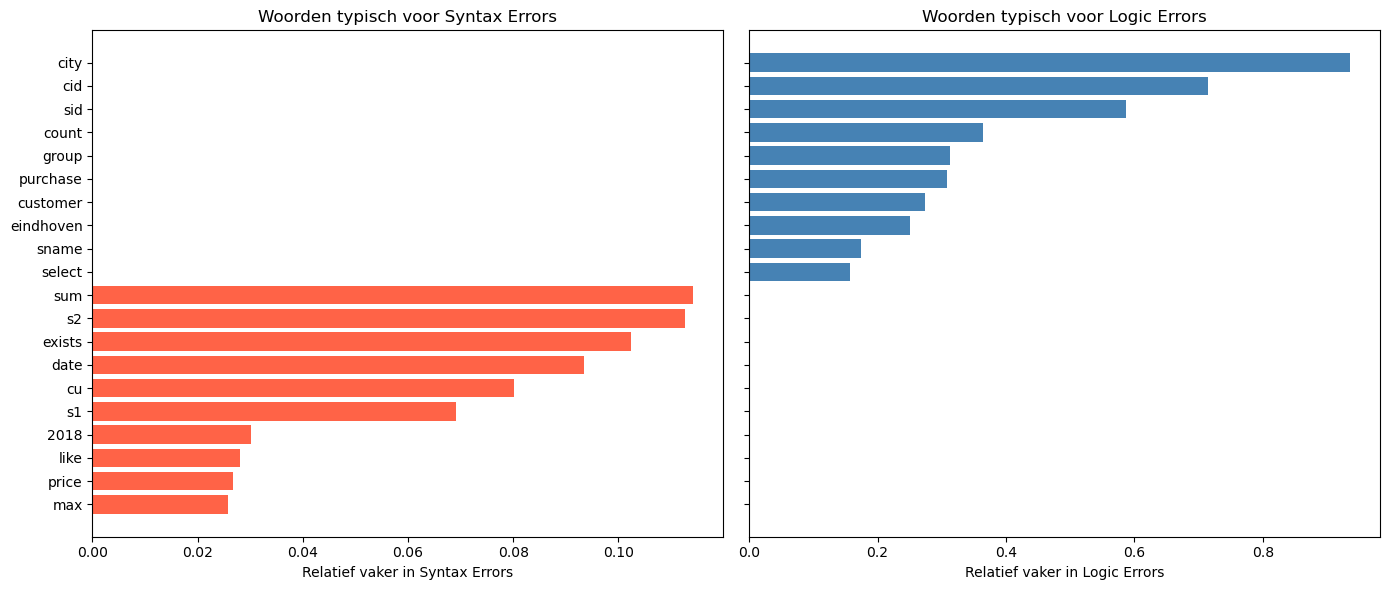

In [119]:
import matplotlib.pyplot as plt

# Top 10 syntax-gerelateerde woorden
syntax_words = avg_freq[avg_freq['Verschil (Syntax - Logic)'] > 0].head(10)

# Top 10 logic-gerelateerde woorden
logic_words = avg_freq[avg_freq['Verschil (Syntax - Logic)'] < 0].tail(10)

# Plot beide barplots naast elkaar
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Syntax
axs[0].barh(syntax_words.index[::-1], syntax_words['Verschil (Syntax - Logic)'][::-1], color='tomato')
axs[0].set_title('Woorden typisch voor Syntax Errors')
axs[0].set_xlabel('Relatief vaker in Syntax Errors')

# Logic
axs[1].barh(logic_words.index, abs(logic_words['Verschil (Syntax - Logic)']), color='steelblue')
axs[1].set_title('Woorden typisch voor Logic Errors')
axs[1].set_xlabel('Relatief vaker in Logic Errors')

plt.tight_layout()
plt.show()


In [218]:
combined_df = combined_df.rename(columns={"50%": "q50"})

combined_attem_df = combined_attem_df.rename(columns={"50%": "q50"})

combined_attem_df_2 = combined_attem_df_2.rename(columns={"50%": "q50"})

In [234]:
print(pivot_table.columns)


Index(['File', '3_2', '3_3', '3_4', '4_3', '4_4', 'Totaal Correct',
       'Unieke Queries Correct', 'Percentage Correct (Uniek)',
       'Percentage Rounded', 'Percentage Category'],
      dtype='object', name='Query Name')


In [881]:
Query_Last_version= duckdb.query('''
select A.*, Pogingen_correct + Pogingen + Herhaling_error + verschillende_error + Fouttype as Struggle_score from (
SELECT C.*, case when "Subquery count" < 0 then 0 else "Subquery count" end as "Subquery count N" ,
case when C.correct = 2 then 1 else 0 end as "Correct New",
ATC."Attempts until correct", case when UC."Unieke Queries Correct" is null then 0 else UC."Unieke Queries Correct" end as "Unieke Queries Correct", case when ET."Aantal Fouttypes" is null then 0 else ET."Aantal Fouttypes" end as "Aantal Fouttypes" ,
    case when C.correct = 2 then 0 else 1 end Fouttype,
    case when "Execution Count" <= CO.q50 then 0 else 1 end Pogingen, 
    case when AT.q50 is null then 1
         when ATC."Attempts until correct" <= AT.q50 then 0 else 1 end Pogingen_correct, 
    case when RS."Repeated Error Count" is null then 0 
         when RS."Repeated Error Count" <= HF.q50_hf then 0 else 1 end as Herhaling_error, 
    case when ET."Aantal Fouttypes" is null then 0 
         when ET."Aantal Fouttypes" > ETS.mean then 1 else 0 end as verschillende_error,
    case when Query like'%<%' or Query like '%>%' or Query like '%=%' then 1 else 0 end as Comparison_Operator
FROM Query_correct as C
left join combined_df as CO
on C."Query Name" = CO."Query Name"
left join attempts_df as ATC
on C."Query Name" = ATC."Query Name" AND C.File = ATC.File
left join combined_attem_df as AT
on C."Query Name" = AT."Query Name"
left join repeated_summary as  RS 
on C."Query Name" = RS."Query Name" AND C.File = RS.File
left join (
    select "Query Name", q50 as q50_hf
    from combined_attem_df_2
) as HF
on C."Query Name" = HF."Query Name"
left join pivot_table as UC
on C."File" = UC."File"
left join unique_error_types as ET
on C."Query Name" = ET."Query Name" AND C.File = ET.File
left join combined_error_type_stats as ETS
on C."Query Name" = ETS."Query Name") as A 
where Query not in ('PUT YOUR HERE', '#')

''').to_df()


kolommen_om_verwijderen = ['Pogingen_correct', 'Pogingen', 'Herhaling_error', 'verschillende_error', 'Fouttype', 'Time Spent (seconds)', 'Time Spent (minutes)', 'Contains error', 'Error Type', 'Subquery count']
Query_Last_version_clean = Query_Last_version.drop(columns=kolommen_om_verwijderen)

display(Query_Last_version_clean)


csv_output_path = 'C:/Users/NihalBoukhoubza/OneDrive/Scriptie/query_analysis_correct.csv'
Query_Last_version_clean.to_csv(csv_output_path, index=False, encoding='utf-8')
print(f"CSV file successfully saved at: {csv_output_path}")


,Folder,File,Timestamp,Query Name,Query,Error Message,Bracket Count,Table Count,Where Count,Group By Count,...,Execution Count,correct,New Error Type,Subquery count N,Correct New,Attempts until correct,Unieke Queries Correct,Aantal Fouttypes,Comparison_Operator,Struggle_score
0,submissions_week3,pp13.py,2020-11-26 20:38:36,3_2,"SELECT cName, cID FROM customer AS c, shopping...",ambiguous column name: cID,0,3,1,0,...,29,1,Logic Error,0,0,0,2,3,1,3
1,submissions_week3,pp13.py,2020-11-26 20:53:07,3_2,"SELECT c.cName, c.cID FROM customer AS c, shop...",,0,3,1,0,...,29,0,Semantic Error,0,0,0,2,3,1,3
2,submissions_week3,pp13.py,2020-11-26 20:54:20,3_2,"SELECT c.cName, c.cID FROM customer AS c, shop...","near "","": syntax error",0,3,1,0,...,29,1,Syntax Error,0,0,0,2,3,1,3
3,submissions_week3,pp13.py,2020-11-26 20:54:27,3_2,"SELECT c.cName, c.cID FROM customer AS c, shop...",,0,3,1,0,...,29,0,Semantic Error,0,0,0,2,3,1,3
4,submissions_week3,pp13.py,2020-11-26 20:54:48,3_2,"SELECT c.cName, c.cID, s.date FROM customer AS...",,0,3,1,0,...,29,0,Semantic Error,0,0,0,2,3,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229,submissions_week3,pp47.py,2020-11-29 17:45:13,3_3,"select distinct c.cName, c.cID from customer a...",,2,3,2,0,...,4,2,Correct,1,1,1,2,0,1,0
4230,submissions_week3,pp47.py,2020-11-29 17:45:36,3_3,"select distinct c.cName, c.cID from customer a...",,2,3,2,0,...,4,2,Correct,1,1,1,2,0,1,0
4231,submissions_week3,pp47.py,2020-11-29 17:45:43,3_3,"select distinct c.cName, c.cID from customer a...",,2,3,2,0,...,4,2,Correct,1,1,1,2,0,1,0
4232,submissions_week3,pp7.py,2020-12-01 19:22:15,3_4,"SELECT DISTINCT cName, customer.cID FROM custo...",,0,3,2,0,...,1,2,Correct,1,1,1,2,0,1,0


CSV file successfully saved at: C:/Users/NihalBoukhoubza/OneDrive/Scriptie/query_analysis_correct.csv


In [186]:
# Zorg dat Timestamp goed geparsed is
df = Query_correct.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sorteer op tijd zodat eerste poging bovenaan staat
df = df.sort_values(['File', 'Query Name', 'Timestamp'])

# Functie om aantal pogingen tot eerste correcte antwoord te tellen
def count_attempts_until_correct(group):
    group = group.sort_values('Timestamp')
    correct_found = group['correct'] == 2

    if correct_found.any():
        # Index van eerste correcte poging
        first_correct_index = correct_found.idxmax()
        attempts = group.index.get_loc(first_correct_index) + 1  # +1 omdat de index 0-based is
    else:
        # Geen correct antwoord: 0 pogingen tot correct antwoord
        attempts = 0

    return pd.Series({'Attempts until correct': attempts})


# Groepeer per student + opdracht
attempts_df = df.groupby(['File', 'Query Name'], group_keys=False)\
    .apply(count_attempts_until_correct)\
    .reset_index()


# Toon resultaat
display(attempts_df)


C:\Users\NihalBoukhoubza\AppData\Local\Temp\ipykernel_26204\3762019206.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(count_attempts_until_correct)\


,File,Query Name,Attempts until correct
0,pp1.py,3_2,0
1,pp1.py,3_3,0
2,pp1.py,3_4,0
3,pp1.py,4_3,0
4,pp1.py,4_4,0
...,...,...,...
208,pp9.py,3_3,0
209,pp9.py,3_4,0
210,pp9.py,4_3,0
211,pp9.py,4_4,0


In [190]:
# ❗ Alleen leerlingen die het ooit goed hadden
filtered_attempts_df = attempts_df[attempts_df['Attempts until correct'] > 0]

# Stats per query, alleen op leerlingen die het uiteindelijk goed deden
boxplot_stats = filtered_attempts_df.groupby('Query Name')['Attempts until correct'].describe()

outlier_counts = []

for query_name, group in filtered_attempts_df.groupby('Query Name'):
    q1 = group['Attempts until correct'].quantile(0.25)
    q3 = group['Attempts until correct'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = group[(group['Attempts until correct'] < lower_bound) | (group['Attempts until correct'] > upper_bound)]
    
    outlier_counts.append({
        'Query Name': query_name,
        'Outlier Count': len(outliers),
        'Outlier %': (len(outliers) / len(group)) * 100
    })

outlier_df = pd.DataFrame(outlier_counts)

# Combineer stats + outliers
boxplot_stats = boxplot_stats.reset_index()
combined_attem_df = pd.merge(boxplot_stats, outlier_df, on='Query Name')

# Alleen querynamen gebruiken die ook echt in de DataFrame zitten
existing_queries = [q for q in sorted_query_names if q in combined_attem_df['Query Name'].values]


# Sorteer (optioneel op jouw volgorde)
combined_attem_df = combined_attem_df.set_index('Query Name').loc[existing_queries].reset_index()


pd.set_option('display.float_format', '{:.2f}'.format)
display(combined_attem_df)



,Query Name,count,mean,std,min,25%,50%,75%,max,Outlier Count,Outlier %
0,3_2,19.00,11.79,12.39,1.00,2.00,8.00,21.50,45.00,0,0.00
1,3_3,14.00,7.14,6.88,1.00,2.50,5.50,9.00,27.00,1,7.14
2,3_4,17.00,5.06,5.66,1.00,1.00,2.00,8.00,18.00,0,0.00
3,4_3,16.00,22.00,20.99,1.00,4.75,16.50,39.00,71.00,0,0.00
4,4_4,4.00,23.25,13.91,13.00,13.75,18.50,28.00,43.00,0,0.00


In [223]:
df = Query_correct.copy()

# Alleen fouten (geen correcte antwoorden)
error_df = df[df['correct'] == 1].copy()

# Tel hoe vaak dezelfde fout voorkomt per student per opdracht
error_counts = (
    error_df.groupby(['File', 'Query Name', 'Error Message'])
    .size()
    .reset_index(name='Error Count')
)


# Filter: alleen herhaalde errors (dus >1)
repeated_errors = error_counts[error_counts['Error Count'] > 1]

# Tel hoeveel unieke errors herhaald zijn per opdracht
repeated_summary = (
    repeated_errors.groupby(['File', 'Query Name'])
    .size()
    .reset_index(name='Repeated Error Count')
)

display(repeated_summary)

,File,Query Name,Repeated Error Count
0,pp1.py,3_2,1
1,pp1.py,3_3,3
2,pp1.py,4_3,1
3,pp1.py,4_4,1
4,pp10.py,3_2,1
...,...,...,...
95,pp7.py,4_3,3
96,pp7.py,4_4,2
97,pp7.py,4_5,1
98,pp9.py,3_3,1


In [215]:

# Stats per query, alleen op leerlingen die het uiteindelijk goed deden
boxplot_stats = repeated_summary.groupby('Query Name')['Repeated Error Count'].describe()

outlier_counts = []

for query_name, group in repeated_summary.groupby('Query Name'):
    q1 = group['Repeated Error Count'].quantile(0.25)
    q3 = group['Repeated Error Count'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = group[(group['Repeated Error Count'] < lower_bound) | (group['Repeated Error Count'] > upper_bound)]
    
    outlier_counts.append({
        'Query Name': query_name,
        'Outlier Count': len(outliers),
        'Outlier %': (len(outliers) / len(group)) * 100
    })

outlier_df = pd.DataFrame(outlier_counts)

# Combineer stats + outliers
boxplot_stats = boxplot_stats.reset_index()
combined_attem_df_2 = pd.merge(boxplot_stats, outlier_df, on='Query Name')

# Alleen querynamen gebruiken die ook echt in de DataFrame zitten
existing_queries = [q for q in sorted_query_names if q in combined_attem_df_2['Query Name'].values]


# Sorteer (optioneel op jouw volgorde)
combined_attem_df_2 = combined_attem_df_2.set_index('Query Name').loc[existing_queries].reset_index()



pd.set_option('display.float_format', '{:.2f}'.format)
display(combined_attem_df_2)



,Query Name,count,mean,std,min,25%,50%,75%,max,Outlier Count,Outlier %
0,3_2,17.00,1.71,1.05,1.00,1.00,1.00,2.00,4.00,2,11.76
1,3_3,18.00,2.06,1.30,1.00,1.00,2.00,2.75,5.00,0,0.00
2,3_4,8.00,1.75,0.89,1.00,1.00,1.50,2.25,3.00,0,0.00
3,4_3,24.00,2.46,1.61,1.00,1.00,2.00,4.00,6.00,0,0.00
4,4_4,17.00,2.82,1.70,1.00,1.00,3.00,4.00,7.00,0,0.00
5,4_5,16.00,2.25,1.29,1.00,1.00,2.00,3.00,5.00,0,0.00


In [253]:
df = Query_correct.copy()

# Alleen fouten (geen correcte antwoorden)
error_df = df[df['New Error Type'] != 'Correct'].copy()

# Tel het aantal unieke fouttypes per student en query
unique_error_types = (
    error_df.groupby(['File', 'Query Name'])['New Error Type']
    .nunique()
    .reset_index(name='Aantal Fouttypes')
)

display(unique_error_types)



,File,Query Name,Aantal Fouttypes
0,pp1.py,3_2,2
1,pp1.py,3_3,3
2,pp1.py,3_4,1
3,pp1.py,4_3,2
4,pp1.py,4_4,2
...,...,...,...
199,pp9.py,3_3,2
200,pp9.py,3_4,2
201,pp9.py,4_3,3
202,pp9.py,4_4,3


In [239]:
# Bereken stats per Query Name op basis van het aantal fouttypes
boxplot_stats = unique_error_types.groupby('Query Name')['Aantal Fouttypes'].describe()

# Outlier-analyse (zelfde structuur als bij repeated errors)
outlier_counts = []

for query_name, group in unique_error_types.groupby('Query Name'):
    q1 = group['Aantal Fouttypes'].quantile(0.25)
    q3 = group['Aantal Fouttypes'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = group[(group['Aantal Fouttypes'] < lower_bound) | (group['Aantal Fouttypes'] > upper_bound)]
    
    outlier_counts.append({
        'Query Name': query_name,
        'Outlier Count': len(outliers),
        'Outlier %': (len(outliers) / len(group)) * 100
    })

outlier_df = pd.DataFrame(outlier_counts)

# Combineer alles
boxplot_stats = boxplot_stats.reset_index()
combined_error_type_stats = pd.merge(boxplot_stats, outlier_df, on='Query Name')

# Zorg dat alleen bestaande queries worden meegenomen
existing_queries = [q for q in sorted_query_names if q in combined_error_type_stats['Query Name'].values]
combined_error_type_stats = combined_error_type_stats.set_index('Query Name').loc[existing_queries].reset_index()

# Toon met juiste decimalen
pd.set_option('display.float_format', '{:.2f}'.format)
display(combined_error_type_stats)


,Query Name,count,mean,std,min,25%,50%,75%,max,Outlier Count,Outlier %
0,3_2,40.00,2.05,0.81,1.00,1.00,2.00,3.00,3.00,0,0.00
1,3_3,39.00,2.00,0.79,1.00,1.00,2.00,3.00,3.00,0,0.00
2,3_4,34.00,1.74,0.67,1.00,1.00,2.00,2.00,3.00,0,0.00
3,4_3,32.00,2.28,0.63,1.00,2.00,2.00,3.00,3.00,0,0.00
4,4_4,29.00,2.24,0.74,1.00,2.00,2.00,3.00,3.00,0,0.00
5,4_5,30.00,2.13,0.90,1.00,1.00,2.00,3.00,3.00,0,0.00


Clustering

In [932]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

clustering_df = Query_Last_version_clean.copy()

# Kolommen die je niet meeneemt
drop_cols = ['Folder','File', 'Query', 'Timestamp', 'Query Name', 'Error Message', 'Query','New Error Type', 'Error Type', 'correct', 'Cluster', 'PCA1', 'PCA2', 'Length Count', 'Execution Count', 'Subquery count', 'Subquery count N','Aantal Fouttypes', 'Correct New', 'From Count', 'Group By & Having', 'Attempts until correct', 'Unieke Queries Correct', 'Where Count', 'Limit Count', 'Order by count', 'Having count']

# Alleen numerieke en relevante features behouden
X = clustering_df.drop(columns=[col for col in drop_cols if col in clustering_df.columns])

X = X.select_dtypes(include='number')

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

display(X)


,Bracket Count,Table Count,Group By Count,Select Count,Join Count,Distinct count,Count Count,Sum Count,Max Count,Union Count,...,Like Count,In Count,with Count,Word Count,Comments Count,Invalid Column Count,Invalid Tables Count,Where Condition Count,Comparison_Operator,Struggle_score
0,0,3,0,1,0,0,0,0,0,0,...,0,1,0,19,0,0,0,1,1,3
1,0,3,0,1,0,0,0,0,0,0,...,0,1,0,19,0,0,0,1,1,3
2,0,3,0,1,0,0,0,0,0,0,...,0,1,0,22,0,0,0,1,1,3
3,0,3,0,1,0,0,0,0,0,0,...,0,1,0,23,0,0,0,1,1,3
4,0,3,0,1,0,0,0,0,0,0,...,0,1,0,24,0,0,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229,2,3,0,2,0,1,0,0,0,0,...,0,2,0,31,0,0,0,4,1,0
4230,2,3,0,2,0,1,0,0,0,0,...,0,2,0,29,0,0,0,3,1,0
4231,2,3,0,2,0,1,0,0,0,0,...,0,2,0,29,0,0,0,3,1,0
4232,0,3,0,2,4,2,0,0,0,0,...,1,6,0,37,0,0,0,5,1,0


PCA

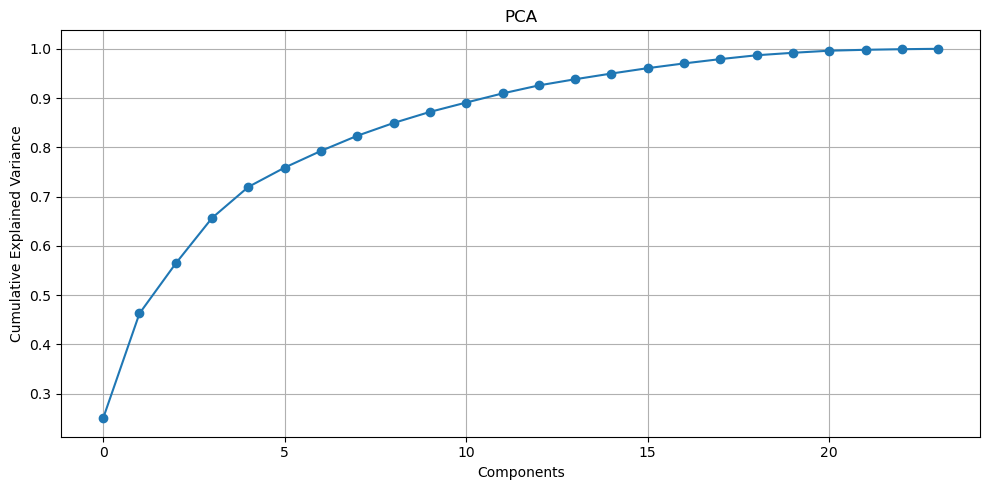

In [933]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA')
plt.grid(True)
plt.tight_layout()
plt.show()


In [934]:
print(cumulative_variance)


[0.25021354 0.46284405 0.56447582 0.65675058 0.71978652 0.75894608
 0.79280184 0.82355896 0.84948157 0.87192935 0.8909662  0.90943788
 0.92571728 0.93824786 0.94983274 0.96074377 0.97033954 0.97911462
 0.98691459 0.99190362 0.99615475 0.99800431 0.99921492 1.        ]


In [935]:
import numpy as np

# Cumulatieve variantie berekenen
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Aantal componenten dat nodig is om minimaal 80% variantie te verklaren
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1  # +1 omdat index vanaf 0 telt

print(f"Aantal componenten voor minimaal 80% is: {n_components_80}")


Aantal componenten voor minimaal 80% is: 8


In [970]:
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled)


Elbow-methode

C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMea

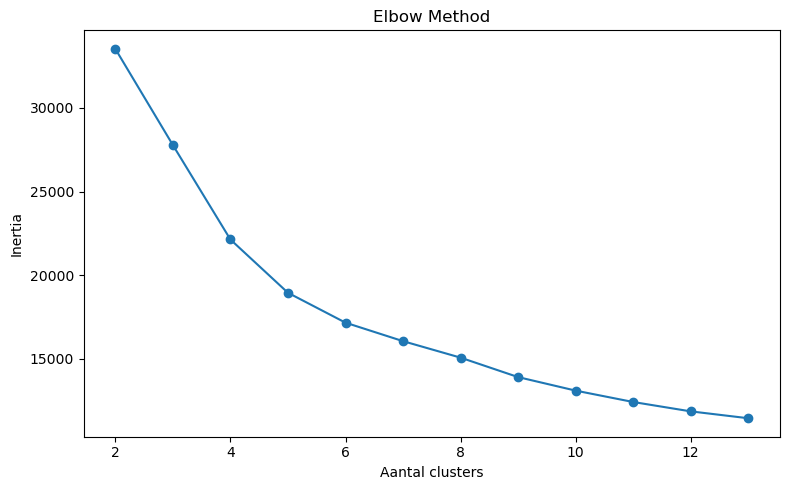

In [971]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X_pca_subset = X_pca[:, :10]

inertia = []
k_range = range(2, 14)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_subset)
    inertia.append(kmeans.inertia_)

# Plot de elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Aantal clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()


Silhouette Score

In [972]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Aantal clusters die je wil testen
k_values = [2,3, 4, 5,6,7, 8, 9, 10]

# Resultaten opslaan
scores = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores[k] = score
    print(f"Silhouette Score for k = {k}: {score:.3f}")


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


Silhouette Score for k = 2: 0.427


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


Silhouette Score for k = 3: 0.222


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


Silhouette Score for k = 4: 0.277


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


Silhouette Score for k = 5: 0.297


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


Silhouette Score for k = 6: 0.246


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


Silhouette Score for k = 7: 0.242


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


Silhouette Score for k = 8: 0.264


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


Silhouette Score for k = 9: 0.279


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


Silhouette Score for k = 10: 0.267


Het vergelijken van meerdere interne clustering-evaluatiemetrics geeft je een veel vollediger beeld van hoe goed jouw clusters zijn – vooral als je geen ground truth labels hebt, zoals in jouw case.

Hier zijn de meest gebruikte interne evaluatiemetrics die je kunt toepassen:

✅ 1. Silhouette Score (silhouette_score)
Meet hoe dicht een punt bij zijn eigen cluster zit versus bij het dichtstbijzijnde andere cluster.

Range: -1 (slecht) tot 1 (goed)

Doel: Hoe "strak" en "gescheiden" zijn je clusters?

✅ 2. Davies-Bouldin Index (davies_bouldin_score)
Lager is beter.

Combineert intra-cluster distance en inter-cluster separation.

Voordeel: Is robuust, vooral als de clusters een verschillende grootte hebben.

✅ 3. Calinski-Harabasz Index (calinski_harabasz_score)
Ook wel de Variance Ratio Criterion.

Hoger is beter.

Vergelijkt de between-cluster dispersion met de within-cluster dispersion.


-Hoe vergelijk je?
Silhouette hoog & Davies-Bouldin laag? → goede clusters.

Calinski-Harabasz hoog? → clusters zijn goed gescheiden met weinig interne spreiding.

Als de metrics verschillen van mening → kijk naar je PCA/t-SNE visualisatie om te interpreteren.

Dit geeft dus aan dat op dit moment 5 clusters het beste is.

In [952]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

metrics = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)  # of X_scaled

    metrics.append({
        'k': k,
        'silhouette': silhouette_score(X_pca, labels),
        'davies_bouldin': davies_bouldin_score(X_pca, labels),
        'calinski_harabasz': calinski_harabasz_score(X_pca, labels),
    })

df_metrics = pd.DataFrame(metrics)
display(df_metrics.sort_values(by='silhouette', ascending=False))  # of een andere kolom


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMea

,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.43,1.56,1243.53
3,5,0.30,1.10,1362.90
7,9,0.28,1.23,1118.59
2,4,0.28,1.31,1353.33
8,10,0.27,1.27,1084.36
6,8,0.26,1.26,1133.62
4,6,0.25,1.30,1291.46
5,7,0.24,1.36,1198.50
1,3,0.22,1.34,1188.12


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMea

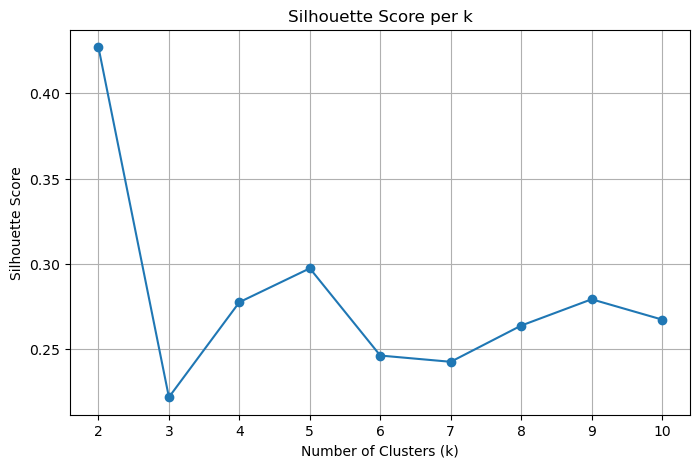

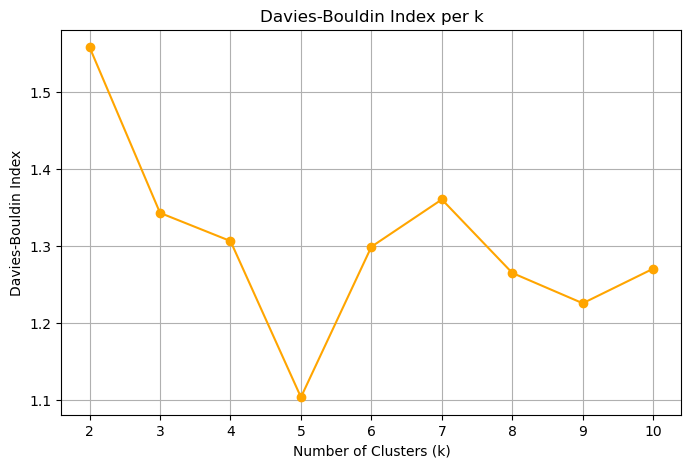

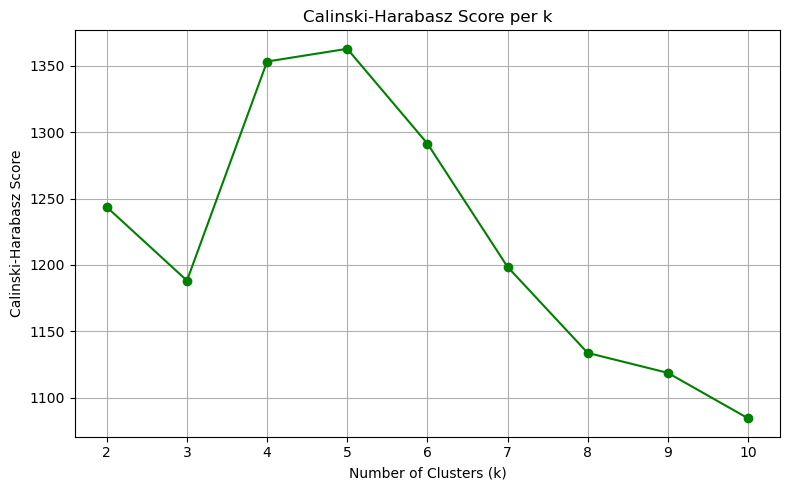

In [973]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Assuming X_pca is already defined and available in the session

# Placeholder to simulate X_pca for plotting (only needed if X_pca is missing)
# from sklearn.datasets import make_blobs
# X_pca, _ = make_blobs(n_samples=500, centers=4, n_features=2, random_state=42)

# Compute clustering metrics
metrics = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)

    metrics.append({
        'k': k,
        'silhouette': silhouette_score(X_pca, labels),
        'davies_bouldin': davies_bouldin_score(X_pca, labels),
        'calinski_harabasz': calinski_harabasz_score(X_pca, labels),
    })

df_metrics = pd.DataFrame(metrics)

# Create three separate line plots
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(df_metrics['k'], df_metrics['silhouette'], marker='o')
ax1.set_title('Silhouette Score per k')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.grid(True)

fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.plot(df_metrics['k'], df_metrics['davies_bouldin'], marker='o', color='orange')
ax2.set_title('Davies-Bouldin Index per k')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Davies-Bouldin Index')
ax2.grid(True)

fig3, ax3 = plt.subplots(figsize=(8, 5))
ax3.plot(df_metrics['k'], df_metrics['calinski_harabasz'], marker='o', color='green')
ax3.set_title('Calinski-Harabasz Score per k')
ax3.set_xlabel('Number of Clusters (k)')
ax3.set_ylabel('Calinski-Harabasz Score')
ax3.grid(True)

plt.tight_layout()
plt.show()


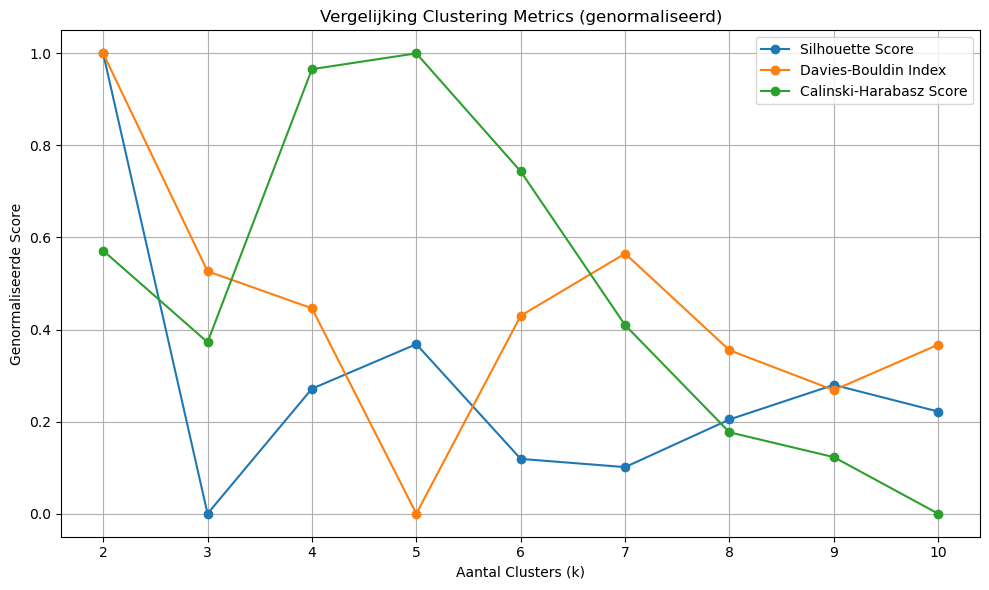

In [983]:
import matplotlib.pyplot as plt

# Genormaliseerde versies van de scores (tussen 0 en 1) zodat ze op 1 as passen
df_metrics_norm = df_metrics.copy()
df_metrics_norm['silhouette'] = (df_metrics['silhouette'] - df_metrics['silhouette'].min()) / (df_metrics['silhouette'].max() - df_metrics['silhouette'].min())
df_metrics_norm['davies_bouldin'] = (df_metrics['davies_bouldin'] - df_metrics['davies_bouldin'].min()) / (df_metrics['davies_bouldin'].max() - df_metrics['davies_bouldin'].min())
df_metrics_norm['calinski_harabasz'] = (df_metrics['calinski_harabasz'] - df_metrics['calinski_harabasz'].min()) / (df_metrics['calinski_harabasz'].max() - df_metrics['calinski_harabasz'].min())

# Plotten
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['k'], df_metrics_norm['silhouette'], label='Silhouette Score', marker='o')
plt.plot(df_metrics['k'], df_metrics_norm['davies_bouldin'], label='Davies-Bouldin Index', marker='o')
plt.plot(df_metrics['k'], df_metrics_norm['calinski_harabasz'], label='Calinski-Harabasz Score', marker='o')
plt.xlabel('Aantal Clusters (k)')
plt.ylabel('Genormaliseerde Score')
plt.title('Vergelijking Clustering Metrics (genormaliseerd)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Je wilt dus:

✅ Voor de "original" silhouette score: gebruik maken van de volledige data, geschaald met StandardScaler.

✅ Voor de "PCA" silhouette score: gebruik maken van RobustScaler + PCA (met 9 componenten).

In [955]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------
# Stap 1: Data voorbereiden
# -----------------------------
clustering_df = Query_Last_version_clean.copy()

drop_cols = ['Folder','File', 'Query', 'Timestamp', 'Query Name', 'Error Message', 'Query','New Error Type', 
             'Error Type', 'correct', 'Cluster', 'PCA1', 'PCA2', 'Length Count', 'Execution Count', 
             'Subquery count', 'Subquery count N','Aantal Fouttypes', 'Correct New', 'From Count', 
             'Group By & Having', 'Attempts until correct', 'Unieke Queries Correct', 
             'Where Count', 'Limit Count', 'Order by count', 'Having count']

X = clustering_df.drop(columns=[col for col in drop_cols if col in clustering_df.columns])
X = X.select_dtypes(include='number')

# -----------------------------
# Stap 2: Original (StandardScaler)
# -----------------------------
scaler_std = StandardScaler()
X_scaled_original = scaler_std.fit_transform(X)

# -----------------------------
# Stap 3: PCA (RobustScaler → PCA with 9 components)
# -----------------------------
scaler_robust = RobustScaler()
X_scaled_robust = scaler_robust.fit_transform(X)

pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled_robust)

# -----------------------------
# Stap 4: Silhouette scores voor beide
# -----------------------------
k_range = range(2, 11)
results = []

for k in k_range:
    km_original = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km_pca = KMeans(n_clusters=k, random_state=42, n_init='auto')

    lbl_original = km_original.fit_predict(X_scaled_original)
    lbl_pca = km_pca.fit_predict(X_pca)

    results.append({
        'k': k,
        'silhouette_original': silhouette_score(X_scaled_original, lbl_original),
        'silhouette_pca': silhouette_score(X_pca, lbl_pca)
    })

results_df = pd.DataFrame(results)
display(results_df.sort_values(by='silhouette_pca', ascending=False))


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMea

,k,silhouette_original,silhouette_pca
0,2,0.32,0.43
3,5,0.20,0.30
7,9,0.23,0.28
2,4,0.21,0.28
8,10,0.22,0.27
6,8,0.21,0.26
4,6,0.21,0.25
5,7,0.22,0.24
1,3,0.18,0.22


Visualisatie in 2D met PCA-reductie

C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\AppData\Local\Temp\ipykernel_26204\957819755.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', chosen_k)  # of 'gist_rainbow', 'nipy_spectral'


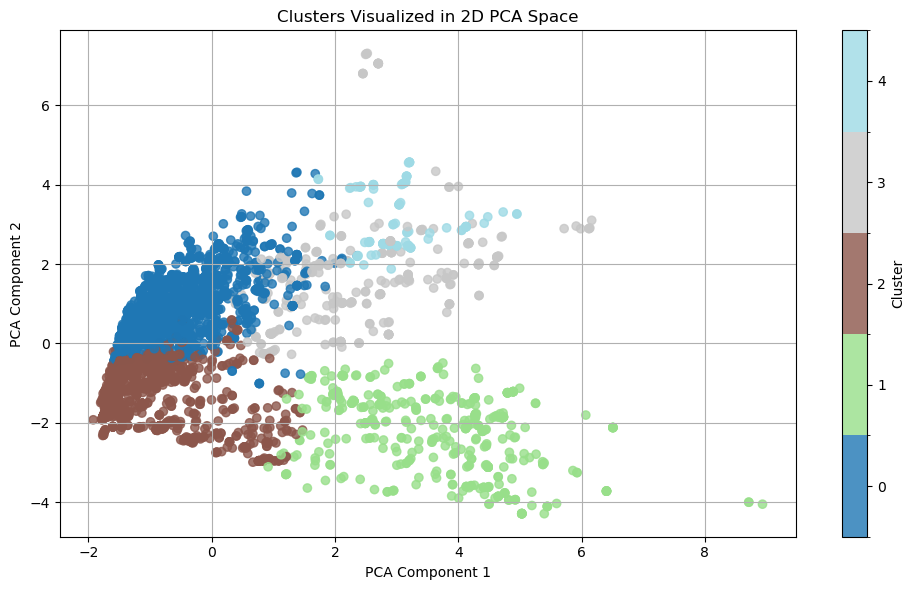

In [906]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Zelf kiezen
chosen_k = 5
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_pca)

# PCA naar 2D
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_scaled)

# Unieke clusters
unique_clusters = np.unique(cluster_labels)

# Gebruik colormap met genoeg kleuren
cmap = plt.cm.get_cmap('tab20', chosen_k)  # of 'gist_rainbow', 'nipy_spectral'
norm = BoundaryNorm(boundaries=np.arange(-0.5, chosen_k + 0.5, 1), ncolors=chosen_k)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=cluster_labels, cmap=cmap, norm=norm, alpha=0.8)
cbar = plt.colorbar(scatter, ticks=unique_clusters)
cbar.set_label("Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters Visualized in 2D PCA Space")
plt.grid(True)
plt.tight_layout()
plt.show()



In [907]:
from sklearn.metrics import silhouette_samples
import numpy as np
import pandas as pd

silhouette_vals = silhouette_samples(X_scaled, cluster_labels)

# Combineer per cluster
df_sil = pd.DataFrame({'Cluster': cluster_labels, 'Silhouette': silhouette_vals})
cluster_scores = df_sil.groupby('Cluster')['Silhouette'].mean().sort_values(ascending=False)
display(cluster_scores)

Cluster
4   0.40
2   0.35
1   0.26
0   0.17
3   0.15
Name: Silhouette, dtype: float64

C:\Users\NihalBoukhoubza\AppData\Local\Temp\ipykernel_26204\3669367927.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', chosen_k)  # of 'gist_rainbow', 'nipy_spectral'


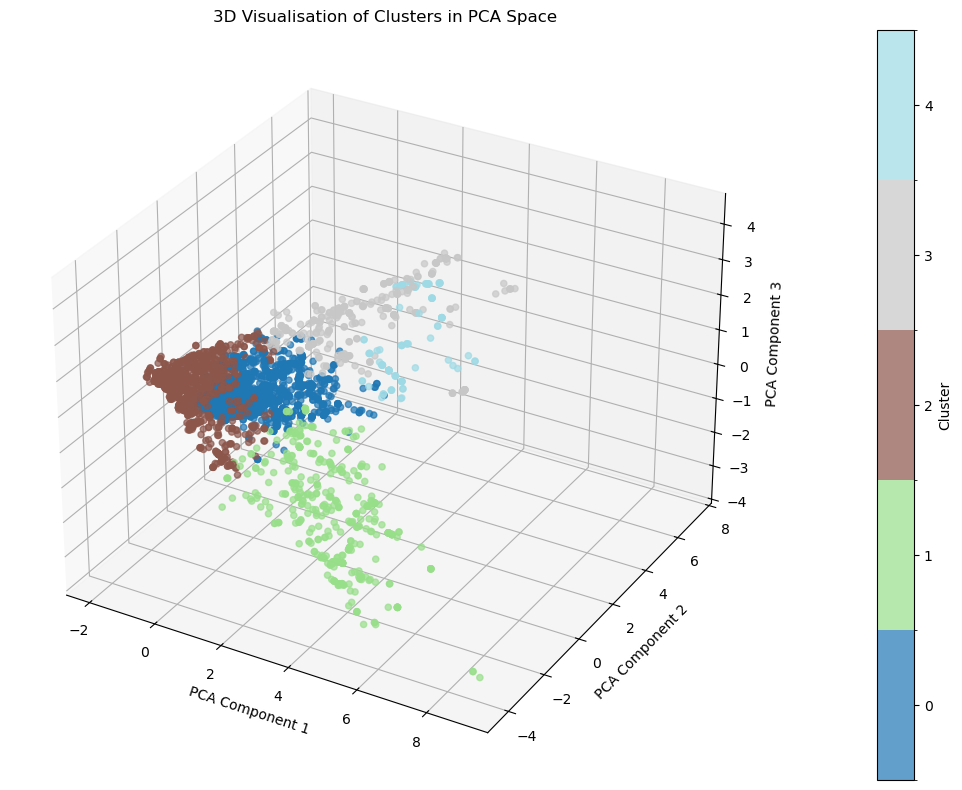

In [908]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

# Reduceer naar 3 componenten voor 3D visualisatie
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_scaled)

# Definieer kleuren voor elk cluster
# Gebruik standaard matplotlib colormap
cmap = plt.cm.get_cmap('tab20', chosen_k)  # of 'gist_rainbow', 'nipy_spectral'
norm = BoundaryNorm(boundaries=np.arange(-0.5, chosen_k + 0.5, 1), ncolors=chosen_k)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=cluster_labels, cmap=cmap, norm=norm, alpha=0.7)

ax.set_title("3D Visualisation of Clusters in PCA Space")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# Kleurlegenda
cbar = plt.colorbar(scatter, ticks=np.unique(cluster_labels), pad=0.1)
cbar.set_label('Cluster')

plt.tight_layout()
plt.show()


Correlatie overzicht huidige kolommen

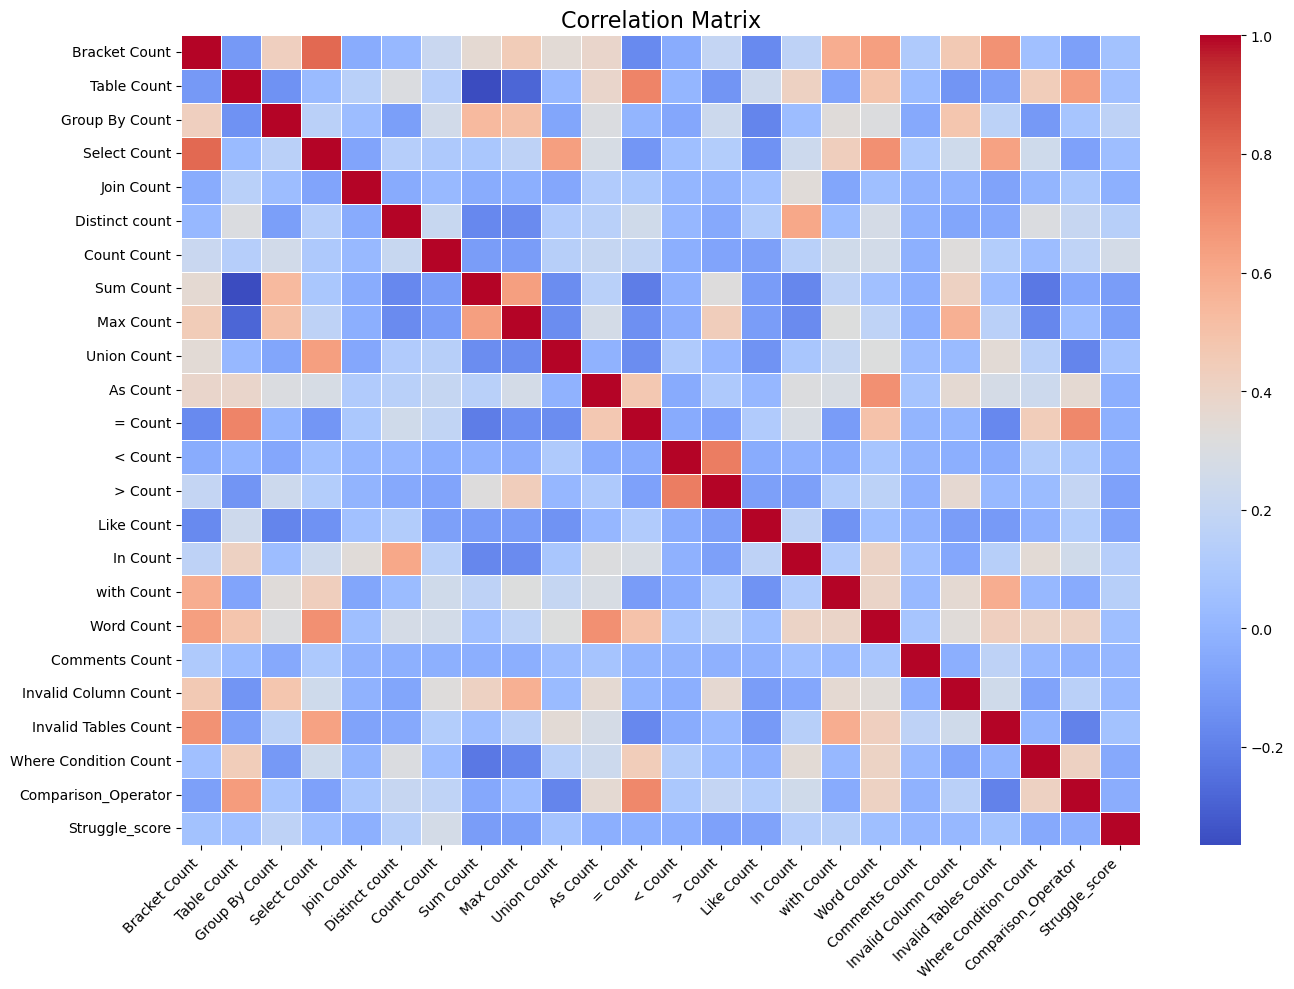

In [909]:
correlation_matrix = X.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [910]:
import pandas as pd

# Genereer de correlatiematrix
correlation_matrix = X.corr(numeric_only=True)

# Zet om naar een lange vorm (twee kolommen: feature 1 en feature 2)
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Filter alleen unieke paren (boven de diagonaal) en met correlatie > 0.5
correlation_pairs = correlation_pairs[correlation_pairs['Feature 1'] != correlation_pairs['Feature 2']]
correlation_pairs = correlation_pairs.drop_duplicates(subset=['Correlation'])
strong_corr = correlation_pairs[correlation_pairs['Correlation'].abs() >= 0.5]

# Sorteer op sterkte van correlatie
strong_corr = strong_corr.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

# Toon het resultaat
display(strong_corr)


,Feature 1,Feature 2,Correlation
0,Bracket Count,Select Count,0.80
1,< Count,> Count,0.75
2,Table Count,= Count,0.73
3,= Count,Comparison_Operator,0.71
4,Select Count,Word Count,0.69
5,As Count,Word Count,0.69
6,Bracket Count,Invalid Tables Count,0.68
7,Table Count,Comparison_Operator,0.65
8,Bracket Count,Word Count,0.64
9,Sum Count,Max Count,0.64


DBSCAN

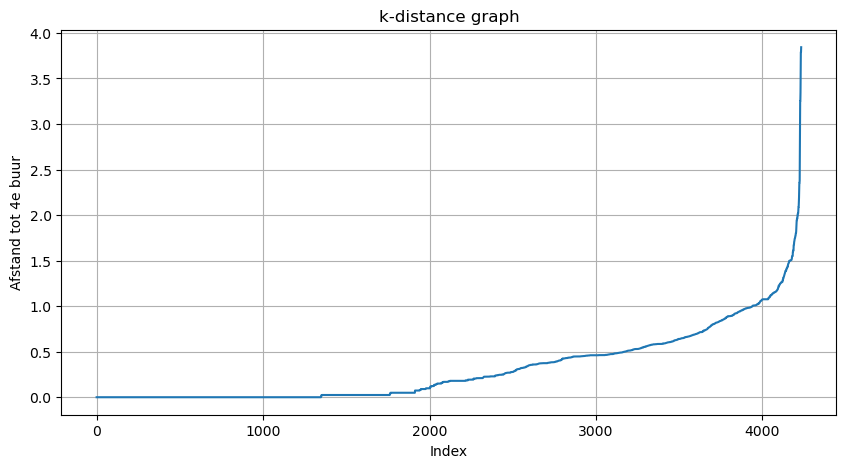

In [853]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# We nemen de 4 dichtstbijzijnde buren (min_samples = 4)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Sorteer op afstand naar de 4e dichtste buur
distances = np.sort(distances[:, 3])

# Plot de afstanden
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title("k-distance graph")
plt.xlabel("Index")
plt.ylabel("Afstand tot 4e buur")
plt.grid(True)
plt.show()


In [854]:
from sklearn.cluster import DBSCAN

# Voer DBSCAN uit met gekozen eps
dbscan = DBSCAN(eps=1.8, min_samples=22)
dbscan_labels = dbscan.fit_predict(X_pca)

# Aantal clusters
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Aantal clusters: {n_clusters}")
print(f"Aantal noise points: {n_noise}")


Aantal clusters: 3
Aantal noise points: 165


In [855]:
from sklearn.metrics import silhouette_score

# Alleen niet-noise punten
mask = dbscan_labels != -1
if len(set(dbscan_labels[mask])) > 1:
    sil_score = silhouette_score(X_pca[mask], dbscan_labels[mask])
    print(f"Silhouette Score: {sil_score:.3f}")
else:
    print("Te weinig clusters voor silhouette score.")


Silhouette Score: 0.475


In [856]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd

# Ranges voor tuning
min_samples_range = range(2, 31, 2)
eps_values = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]

results = []

for eps in eps_values:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters > 1:
            score = silhouette_score(X_pca, labels)
        else:
            score = None

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': score
        })

results_df = pd.DataFrame(results)
display(results_df.sort_values('silhouette_score', ascending=False).head())

,eps,min_samples,n_clusters,n_noise,silhouette_score
141,2.00,14,3,61,0.46
138,2.00,8,4,44,0.45
143,2.00,18,3,74,0.45
142,2.00,16,3,73,0.45
139,2.00,10,4,46,0.45


Agglomerative Clustering 

In [857]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=7)
agglo_labels = agglo.fit_predict(X_pca)

score = silhouette_score(X_pca, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {score:.3f}")


Agglomerative Clustering Silhouette Score: 0.230


In [858]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

scores = []
range_n = range(2, 15)

for k in range_n:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores.append((k, score))

import pandas as pd
scores_df = pd.DataFrame(scores, columns=['n_clusters', 'silhouette_score'])
display(scores_df.sort_values(by='silhouette_score', ascending=False))


,n_clusters,silhouette_score
0,2,0.39
3,5,0.26
7,9,0.24
2,4,0.24
6,8,0.24
4,6,0.23
5,7,0.23
12,14,0.22
11,13,0.22
10,12,0.21


Gaussian Mixture Model (GMM)

In [859]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

score = silhouette_score(X_pca, gmm_labels)
print(f"GMM Silhouette Score: {score:.3f}")


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


GMM Silhouette Score: 0.116


Feature selection:
Deze code geeft aan welke kolommen een lage variante hebben. 

Bij clustering, PCA en andere unsupervised methodes wil je alleen features gebruiken die voldoende verschillen over je samples. Ik heb in dit geval gekeken naar waardes gelijk en onder de 20%

In [885]:
# Alleen kolommen met waarden die 0 en 1 zijn (typisch voor booleans)
boolean_columns = [col for col in X.columns if set(X[col].dropna().unique()).issubset({0, 1})]

# Maak een subset van X alleen met die kolommen
X_boolean = X[boolean_columns]

# Bereken varianties van alleen deze boolean kolommen
variances = X_boolean.var()

# Filter kolommen met lage variantie (<= 0.2)
low_variance_columns = variances[variances <= 0.2].sort_values()

display(low_variance_columns)



Series([], dtype: float64)

Clustering zonder PCA
We gebruiken gewoon de geschaalde data (X_scaled) zonder deze eerst te reduceren met PCA:

In [976]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Resultaten opslaan
metrics_no_pca = []

# Clustering zonder PCA
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=500)
    labels = kmeans.fit_predict(X_scaled)

    metrics_no_pca.append({
        'k': k,
        'silhouette': silhouette_score(X_scaled, labels),
        'davies_bouldin': davies_bouldin_score(X_scaled, labels),
        'calinski_harabasz': calinski_harabasz_score(X_scaled, labels)
    })

# Zet om naar DataFrame
df_no_pca = pd.DataFrame(metrics_no_pca)

# Tabel tonen
display(df_no_pca)


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMea

,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.39,1.76,1014.23
1,3,0.35,1.62,973.72
2,4,0.22,1.50,1011.33
3,5,0.24,1.31,977.03
4,6,0.22,1.55,905.39
5,7,0.22,1.54,839.11
6,8,0.22,1.59,788.51
7,9,0.21,1.52,745.87
8,10,0.21,1.51,715.92


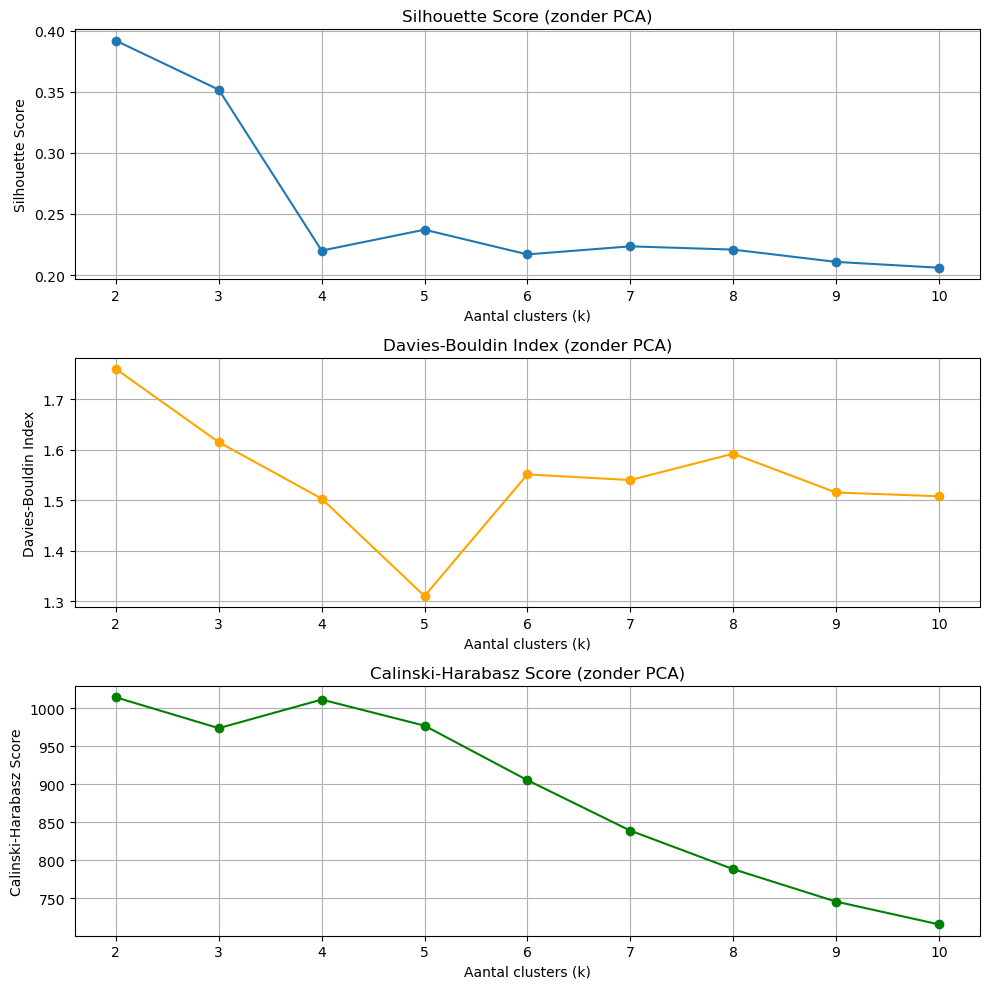

In [977]:
plt.figure(figsize=(10, 10))

# Silhouette
plt.subplot(3, 1, 1)
plt.plot(df_no_pca['k'], df_no_pca['silhouette'], marker='o')
plt.title('Silhouette Score (zonder PCA)')
plt.xlabel('Aantal clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Davies-Bouldin
plt.subplot(3, 1, 2)
plt.plot(df_no_pca['k'], df_no_pca['davies_bouldin'], marker='o', color='orange')
plt.title('Davies-Bouldin Index (zonder PCA)')
plt.xlabel('Aantal clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)

# Calinski-Harabasz
plt.subplot(3, 1, 3)
plt.plot(df_no_pca['k'], df_no_pca['calinski_harabasz'], marker='o', color='green')
plt.title('Calinski-Harabasz Score (zonder PCA)')
plt.xlabel('Aantal clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)

plt.tight_layout()
plt.show()


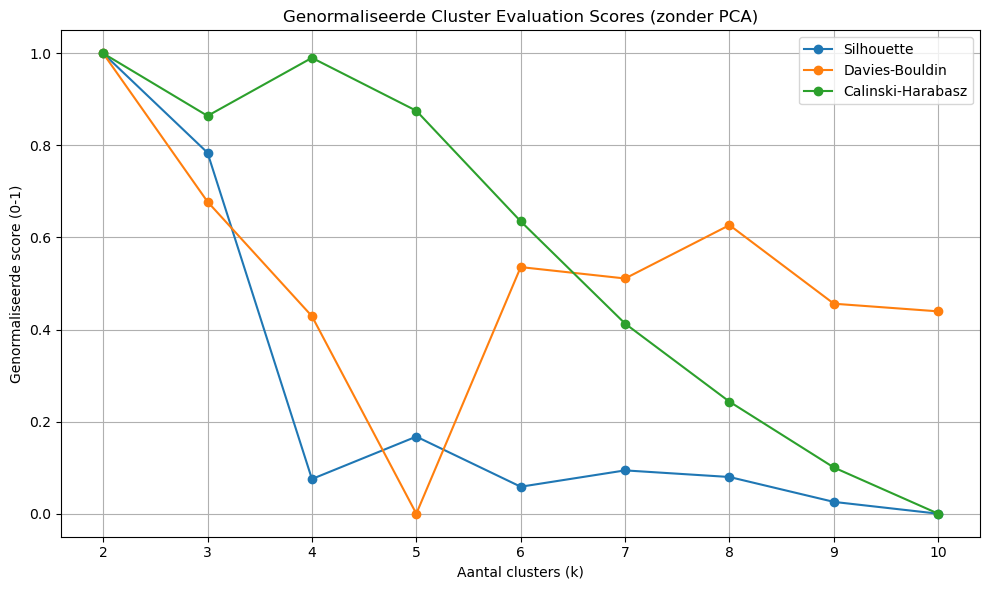

In [979]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Normaliseer de waarden per kolom
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_no_pca[['silhouette', 'davies_bouldin', 'calinski_harabasz']])
normalized_df = pd.DataFrame(normalized_data, columns=['silhouette', 'davies_bouldin', 'calinski_harabasz'])
normalized_df['k'] = df_no_pca['k']

# Plot alle genormaliseerde scores in één grafiek
plt.figure(figsize=(10, 6))
plt.plot(normalized_df['k'], normalized_df['silhouette'], marker='o', label='Silhouette')
plt.plot(normalized_df['k'], normalized_df['davies_bouldin'], marker='o', label='Davies-Bouldin')
plt.plot(normalized_df['k'], normalized_df['calinski_harabasz'], marker='o', label='Calinski-Harabasz')
plt.title('Genormaliseerde Cluster Evaluation Scores (zonder PCA)')
plt.xlabel('Aantal clusters (k)')
plt.ylabel('Genormaliseerde score (0-1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\NihalBoukhoubza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


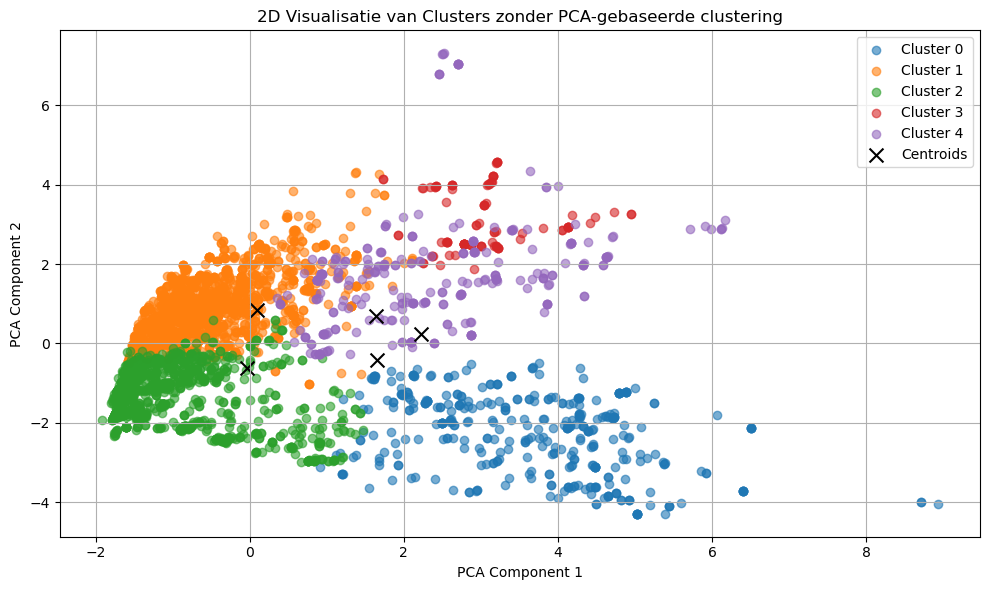

In [981]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduceer naar 2D voor visualisatie
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_scaled)

# KMeans clustering uitvoeren met het beste aantal clusters (bijvoorbeeld k=3 voor illustratie)
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50, max_iter=500)
labels = kmeans.fit_predict(X_scaled)

# Visualisatie
plt.figure(figsize=(10, 6))
for i in range(best_k):
    plt.scatter(X_vis[labels == i, 0], X_vis[labels == i, 1], label=f"Cluster {i}", alpha=0.6)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='x', s=100, label='Centroids')
plt.title("2D Visualisatie van Clusters zonder PCA-gebaseerde clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
